<a href="https://colab.research.google.com/github/Chou-fang/ART1/blob/main/k_means_ART_CNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # 如果在 Colab

# 你的原始影像
# image = cv2.imread('your_image.jpg')
output_image = image.copy()  # 建一張複製的影像，避免修改原圖

# 所有門的座標
all_door = [
    np.array([[634, 233], [740, 233], [738, 319], [634, 321]]),
    np.array([[499, 234], [602, 229], [607, 318], [509, 320]]),
    np.array([[379, 268], [470, 265], [477, 323], [469, 331], [464, 339], [465, 346], [466, 351], [396, 351], [386, 321]]),
    np.array([[266, 250], [345, 248], [356, 327], [281, 332]]),
    np.array([[182, 266], [243, 263], [254, 326], [251, 330], [246, 337], [197, 340]])
]

# 進階版 for-loop
for idx, door_poly in enumerate(all_door, start=1):
    # 計算外接矩形
    x, y, w, h = cv2.boundingRect(door_poly)

    # 建立 mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [door_poly], 255)

    # 遮罩影像
    masked_img = cv2.bitwise_and(image, image, mask=mask)

    # 裁切 ROI
    roi = masked_img[y:y+h, x:x+w]

    # 計算面積
    area = cv2.contourArea(door_poly)

    # 🔥 在 output_image 上畫出門的輪廓
    cv2.polylines(output_image, [door_poly], isClosed=True, color=(0, 255, 0), thickness=2)

    # 🔥 在門的外接矩形左上角標註 Door 編號
    text_position = (x, y - 10) if y - 10 > 10 else (x, y + 20)  # 避免文字太上面跑出圖外
    cv2.putText(output_image, f'Door {idx}', text_position,
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # 印出門的資訊
    print(f"Door {idx}: 面積 = {area:.2f} (pixels)")

    # 顯示每個門的 ROI
    cv2_imshow(roi)

    # 儲存 ROI（可選）
    # cv2.imwrite(f'door_{idx}_roi.png', roi)

# 🔥 最後，顯示整張標註後的總圖
print("標註完畢，顯示整體影像：")
cv2_imshow(output_image)

# 儲存標註後的影像（可選）
# cv2.imwrite('output_with_doors.png', output_image)


In [ ]:
all_door = [
    np.array([[634,233],[740,233],[738,319],[634,321]]),
    np.array([[499,234],[602,229],[607,318],[509,320]]),
    np.array([[379,268],[470,265],[477,323],[469,331],[464,339],[465,346],[466,351],[396,351],[386,321]]),
    np.array([[266,250],[345,248],[356,327],[281,332]]),
    np.array([[182,266],[243,263],[254,326],[251,330],[246,337],[197,340]])
 ]

polygons = [
    np.array([[626,207],[741,207],[736,321],[634,325]]), # door_cell_1
    np.array([[490,211],[605,208],[607,320],[502,326]]), # door_cell_2
    np.array([[363,219],[469,215],[478,350],[383,353]]), # door_cell_3
    np.array([[252,232],[343,225],[357,334],[270,338]]), # door_cell_4
    np.array([[160,244],[236,234],[249,333],[181,345]])] # door_cell_5
image_copy = image.copy()

# 每個 door 做處理
for i, (poly, door) in enumerate(zip(polygons, all_door)):
    poly_x, poly_y, poly_w, poly_h = cv2.boundingRect(poly)
    door_x, door_y, door_w, door_h = cv2.boundingRect(door)

    mask = np.zeros(image.shape[:2], dtype=np.uint8) # 建立空的 mask
    cv2.fillPoly(mask, [poly], 255) # 繪製多邊形到 mask 上（白色）
    masked_img = cv2.bitwise_and(image, image, mask=mask) # 對原圖做遮罩
    masked_img[poly_y:poly_y+poly_h, poly_x:poly_x+poly_w] = 0
    image_copy[poly_y:poly_y+poly_h, poly_x:poly_x+poly_w] = masked_img[poly_y:poly_y+poly_h, poly_x:poly_x+poly_w] # 裁切 ROI（僅取 bounding box 區域）

    # roi = masked_img[y:y+h, x:x+w] # 裁切 ROI（僅取 bounding box 區域）

    # area = cv2.contourArea(door) # 計算面積

    cv2_imshow(image_copy) # 顯示與儲存結果


In [3]:
class ART1:
    def __init__(self, input_size, vigilance=0.8, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.num_categories = 0
        self.bottom_up_weights = []
        self.top_down_weights = []

    def _match(self, input_vec, top_down_weight):
        # 計算匹配度
        numerator = np.sum(np.logical_and(input_vec, top_down_weight))
        denominator = np.sum(input_vec) + self.epsilon
        return numerator / denominator

    def _activate(self, input_vec):
        activations = []
        for w in self.bottom_up_weights:
            activations.append(np.sum(np.logical_and(input_vec, w)))
        return activations

    def _update_weights(self, index, input_vec):
        # 更新 top-down
        self.top_down_weights[index] = np.logical_and(input_vec, self.top_down_weights[index]).astype(int)
        # 更新 bottom-up
        numer = np.logical_and(input_vec, self.top_down_weights[index]).astype(int)
        denom = self.epsilon + np.sum(numer)
        self.bottom_up_weights[index] = numer / denom

    def train(self, input_vec):
        if self.num_categories == 0:
            # 初始第一類別
            self.top_down_weights.append(input_vec.copy())
            self.bottom_up_weights.append(input_vec / (self.epsilon + np.sum(input_vec)))
            self.num_categories += 1
            return 0

        activations = self._activate(input_vec)
        candidates = np.argsort(activations)[::-1]  # 從高到低排序

        for index in candidates:
            match_score = self._match(input_vec, self.top_down_weights[index])
            if match_score >= self.vigilance:
                self._update_weights(index, input_vec)
                return index  # 成功分類

        # 無法匹配任何一類別 → 建立新類別
        self.top_down_weights.append(input_vec.copy())
        self.bottom_up_weights.append(input_vec / (self.epsilon + np.sum(input_vec)))
        self.num_categories += 1
        return self.num_categories - 1


In [ ]:
##由此開始

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import pandas as pd

In [2]:

image = cv2.imread('/content/drive/MyDrive/night/2024-08-03_79.jpg')
# image = cv2.imread('/content/drive/MyDrive/night/2024-12-17_10.jpg')# 無水門
# cv2_imshow(image)
# print(image)

##自適應共振網絡(ART)

In [18]:
class ART1:
    def __init__(self, input_size, vigilance=0.7, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.bottom_up_weights = []
        self.top_down_weights = []
        self.num_categories = 0

    def process_input(self, input_vec):
        if not self.bottom_up_weights:
            self._add_new_category(input_vec)
            return self.num_categories - 1

        activations = []
        for weight in self.bottom_up_weights:
            activation = sum(input_vec[i] * weight[i] for i in range(self.input_size))
            activations.append(activation)

        if activations:
            winner_index = activations.index(max(activations))

        winner_top_down = self.top_down_weights[winner_index]
        numerator = sum(input_vec[i] * winner_top_down[i] for i in range(self.input_size))
        denominator = sum(input_vec) + self.epsilon
        match_score = numerator / denominator

        if match_score >= self.vigilance:
            self._update_weights(winner_index, input_vec)
            return winner_index
        else:
            activations[winner_index] = -1

        while activations and max(activations) != -1:
            winner_index = activations.index(max(activations))
            winner_top_down = self.top_down_weights[winner_index]
            numerator = sum(input_vec[i] * winner_top_down[i] for i in range(self.input_size))
            denominator = sum(input_vec) + self.epsilon
            match_score = numerator / denominator

            if match_score >= self.vigilance:
                self._update_weights(winner_index, input_vec)
                return winner_index
            else:
                activations[winner_index] = -1

        # 全失敗，新增新類別
        self._add_new_category(input_vec)
        return self.num_categories - 1

    def _add_new_category(self, input_vec):
        self.top_down_weights.append(list(input_vec))
        denominator = self.epsilon + sum(input_vec)
        normalized_bottom_up = [val / denominator for val in input_vec]
        self.bottom_up_weights.append(normalized_bottom_up)
        self.num_categories += 1

    def _update_weights(self, index, input_vec):
        self.top_down_weights[index] = [input_vec[i] * self.top_down_weights[index][i] for i in range(self.input_size)]
        denominator = self.epsilon + sum(self.top_down_weights[index])
        self.bottom_up_weights[index] = [val / denominator for val in self.top_down_weights[index]]

##建立基準mask


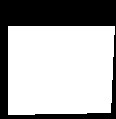

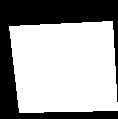

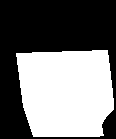

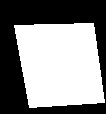

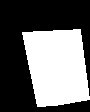

In [4]:

##基準mask
all_door = [
    np.array([[634,233],[740,233],[738,319],[634,321]]),
    np.array([[499,234],[602,229],[607,318],[509,320]]),
    np.array([[379,268],[470,265],[477,323],[469,331],[464,339],[465,346],[466,351],[396,351],[386,321]]),
    np.array([[266,250],[345,248],[356,327],[281,332]]),
    np.array([[182,266],[243,263],[254,326],[251,330],[246,337],[197,340]])
]

polygons = [
    np.array([[626,207],[741,207],[736,321],[634,325]]), # door_cell_1
    np.array([[490,211],[605,208],[607,320],[502,326]]), # door_cell_2
    np.array([[363,219],[469,215],[478,350],[383,353]]), # door_cell_3
    np.array([[252,232],[343,225],[357,334],[270,338]]), # door_cell_4
    np.array([[160,244],[236,234],[249,333],[181,345]])  # door_cell_5
]

image_copy = image.copy()
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

for poly in polygons:
    cv2.fillPoly(image_copy, [poly], 0)

for door in all_door:
    cv2.fillPoly(image_copy, [door], 255)

# cv2_imshow(image_copy)



for i, poly in enumerate(polygons):
    x, y, w, h = cv2.boundingRect(poly)

    # 建立空的 mask
    mask = np.zeros(image_copy.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [poly], 255) # 繪製多邊形到 mask 上（白色）
    masked_img = cv2.bitwise_and(image_copy, image_copy, mask=mask) # 對原圖做遮罩
    globals()['mask_'+str(i)] = masked_img[y:y+h, x:x+w] # 裁切 ROI（僅取 bounding box 區域）

    cv2_imshow(globals()['mask_'+str(i)])




In [ ]:
cv2_imshow(image)

##圖片前處理

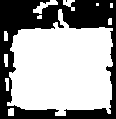

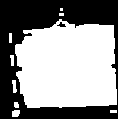

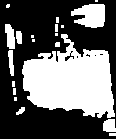

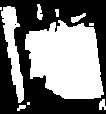

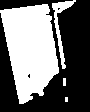

In [57]:

# 圖片前處理
for i, poly in enumerate(polygons):
    x, y, w, h = cv2.boundingRect(poly)

    # 建立空的 mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [poly], 255) # 繪製多邊形到 mask 上（白色）
    masked_img = cv2.bitwise_and(image, image, mask=mask) # 對原圖做遮罩
    roi = masked_img[y:y+h, x:x+w] # 裁切 ROI（僅取 bounding box 區域）

    # 轉換形狀
    pixels = roi.reshape(-1, 3)  # (像素, RGB)

    # KMeans 分群(第一次10群)
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.astype('uint8')
    segmented_image = centers[labels].reshape(h, w, 3)
    # print(1)
    # cv2_imshow(segmented_image)

    # KMeans 分群(第二次5群)
    pixels = segmented_image.reshape(-1, 3)
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.astype('uint8')
    segmented_image = centers[labels].reshape(h, w, 3)
    # print(2)
    # cv2_imshow(segmented_image)

    # # KMeans 分群(第三次5群)
    # pixels = segmented_image.reshape(-1, 3)
    # n_clusters = 5
    # kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    # kmeans.fit(pixels)
    # labels = kmeans.labels_
    # centers = kmeans.cluster_centers_.astype('uint8')
    # segmented_image = centers[labels].reshape(h, w, 3)
    # print(3)
    # cv2_imshow(segmented_image)

    # 取出區塊特徵
    data = pd.DataFrame(columns=['重心_x', '重心_y', '面積', '與最大面積距離'])

    # 計算重心
    y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    cen_x, cen_y = [], []

    for label in range(n_clusters):
        mask = (labels.reshape(h, w) == label)

        if not np.any(mask):
            continue

        x_c = x_coords[mask].mean()
        y_c = y_coords[mask].mean()

        cen_x.append(x_c)
        cen_y.append(y_c)

    # 計算面積
    unique_labels, counts = np.unique(labels, return_counts=True)
    area = counts.tolist()

    # 儲存數據
    data['重心_x'] = cen_x
    data['重心_y'] = cen_y
    data['面積'] = area
    data['index'] = range(len(area))


    # 計算最大面積的索引
    max_index = np.argmax(data['面積'])

    # 計算與最大面積的距離
    dis = np.sqrt((data['重心_x'] - data.loc[max_index, '重心_x'])**2 +
                  (data['重心_y'] - data.loc[max_index, '重心_y'])**2)
    data['與最大面積距離'] = dis
    labels = [1 if value == max_index else 0 for value in labels]

    centers = np.array([[0, 0, 0],[255, 255, 255]])

    segmented_image = centers[labels].reshape(h, w, 3)
    segmented_image = segmented_image.astype(np.float32)

    # 形態學開運算
    kernel = np.ones((3,3), np.uint8)
    erosion = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel)


    # cv2_imshow(segmented_image)
    globals()['erosion_'+str(i)]=cv2.cvtColor(erosion, cv2.COLOR_RGB2GRAY) # 轉灰階(三維降二維)
    cv2_imshow(globals()['erosion_'+str(i)])
    globals()['vector_'+str(i)] = globals()['erosion_'+str(i)].flatten() # 攤平(二維降一維)











In [50]:
import numpy as np

# ========== ART1 類別（只分類版！）==========
class ART1:
    def __init__(self, input_size, vigilance=0.7, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.bottom_up_weights = []
        self.top_down_weights = []
        self.num_categories = 0

    def register_template(self, template_vec):
        """
        事先手動新增一個樣本模板作為類別。
        """
        self.top_down_weights.append(list(template_vec))
        denominator = self.epsilon + sum(template_vec)
        normalized_bottom_up = [val / denominator for val in template_vec]
        self.bottom_up_weights.append(normalized_bottom_up)
        self.num_categories += 1

    def process_input(self, input_vec):
        if not self.bottom_up_weights:
            return -1  # 如果目前沒有任何類別，直接失敗

        activations = []
        for weight in self.bottom_up_weights:
            activation = sum(input_vec[i] * weight[i] for i in range(self.input_size))
            activations.append(activation)

        if activations:
            winner_index = activations.index(max(activations))
        else:
            return -1

        winner_top_down = self.top_down_weights[winner_index]
        numerator = sum(input_vec[i] * winner_top_down[i] for i in range(self.input_size))
        denominator = sum(input_vec) + self.epsilon
        match_score = numerator / denominator

        if match_score >= self.vigilance:
            return winner_index  # 成功分類
        else:
            activations[winner_index] = -1

        while activations and max(activations) != -1:
            winner_index = activations.index(max(activations))
            winner_top_down = self.top_down_weights[winner_index]
            numerator = sum(input_vec[i] * winner_top_down[i] for i in range(self.input_size))
            denominator = sum(input_vec) + self.epsilon
            match_score = numerator / denominator

            if match_score >= self.vigilance:
                return winner_index
            else:
                activations[winner_index] = -1

        return -1  # 全部比對失敗

# ========== 主程式範例 ==========

# 假設你有幾個訓練樣本
a=np.random.randint(0,2,100)
template_vectors = [
    a,  # 樣本模板1（長度100）
    np.random.randint(0,2,100),  # 樣本模板2
    np.random.randint(0,2,100)   # 樣本模板3
]

# 建立 ART1
model = ART1(input_size=100, vigilance=0.8, epsilon=1e-6)

# 先註冊已知的樣本模板
for idx, vec in enumerate(template_vectors):
    model.register_template(vec)
    print(f"註冊模板 {idx+1} 成為類別 {model.num_categories-1}")

# 現在假設你要辨識一些新樣本
test_vectors = [
    a,  # 測試樣本1
    np.random.randint(0,2,100),  # 測試樣本2
    np.random.randint(0,2,100)   # 測試樣本3
]

print("\n=== 開始辨識樣本 ===")
for idx, test_vec in enumerate(test_vectors):
    category = model.process_input(test_vec)
    if category == -1:
        print(f"樣本 {idx+1} 辨識失敗 ❌")
    else:
        print(f"樣本 {idx+1} 成功辨識為類別 {category} ✅")


註冊模板 1 成為類別 0
註冊模板 2 成為類別 1
註冊模板 3 成為類別 2

=== 開始辨識樣本 ===
樣本 1 成功辨識為類別 0 ✅
樣本 2 辨識失敗 ❌
樣本 3 辨識失敗 ❌


In [85]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== ART1 類別 ==========
class ART1:
    def __init__(self, input_size, vigilance=0.7, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.bottom_up_weights = []
        self.top_down_weights = []
        self.num_categories = 0

    def register_template(self, template_vec):
        self.top_down_weights.append(list(template_vec))
        denominator = self.epsilon + sum(template_vec)
        normalized_bottom_up = [val / denominator for val in template_vec]
        self.bottom_up_weights.append(normalized_bottom_up)
        self.num_categories += 1

    def process_input(self, input_vec):
        if not self.bottom_up_weights:
            return -1,0.0

        activations = []
        for weight in self.bottom_up_weights:
            activation = sum(input_vec[i] * weight[i] for i in range(self.input_size))
            activations.append(activation)

        if activations:
            winner_index = activations.index(max(activations))
        else:
            return -1,0.0

        winner_top_down = self.top_down_weights[winner_index]
        numerator = sum(input_vec[i] * winner_top_down[i] for i in range(self.input_size))
        denominator = sum(input_vec) + self.epsilon
        match_score = numerator / denominator

        if match_score >= self.vigilance:
            return winner_index
        else:
            return -1,0.0
        return -1, match_score

# ========== 設定樣本與資料夾 ==========
# 樣本圖片路徑
template_img = mask_0  # ✅ 這是你自己的 mask_0
test_folder = '/content/drive/MyDrive/night/0428/'  # ✅ 測試資料夾
resize_shape = (100, 100)  # Resize 統一大小

# ========== 建立 樣本 ==========
# template_img = cv2.resize(template_img, resize_shape)  # 這邊你不resize沒問題
_, template_binary = cv2.threshold(template_img, 128, 1, cv2.THRESH_BINARY)
template_vector = template_binary.flatten()

model = ART1(input_size=len(template_vector), vigilance=0.9, epsilon=1e-6)
model.register_template(template_vector)
print("✅ 樣本註冊完成")

# ========== 準備辨識資料 ==========
file_list = os.listdir(test_folder)
selected_files = [f for f in file_list if f.endswith('1.jpg') or f.endswith('1.png')]

print(f"\n共找到 {len(selected_files)} 張符合條件的圖片\n")

# ========== 開始辨識 + 收集結果 ==========
results = []  # ⭐ 用來記錄辨識結果

for idx, filename in enumerate(selected_files):
    file_path = os.path.join(test_folder, filename)

    test_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    _, test_binary = cv2.threshold(test_img, 128, 1, cv2.THRESH_BINARY)
    test_vector = test_binary.flatten()

    if len(test_vector) != model.input_size:
        print(f"❌ 圖片 {filename} 大小不符，跳過")
        results.append({'檔名': filename, '辨識結果': '尺寸不符', 'match_score': 0.0})
        continue

    # ✅ 正確寫法：一次接 category 和 match_score！
    category, match_score = model.process_input(test_vector)

    # 收集結果
    if category == -1:
        results.append({'檔名': filename, '辨識結果': 'fail', 'match_score': match_score})
    else:
        results.append({'檔名': filename, '辨識結果': 'success', 'match_score': match_score})


    # # 顯示樣本 vs 測試圖
    # fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    # axs[0].imshow(template_img, cmap='gray')
    # axs[0].set_title('樣本')
    # axs[0].axis('off')
    # axs[1].imshow(test_img, cmap='gray')
    # axs[1].set_title(f'圖片 {filename}')
    # axs[1].axis('off')
    # plt.suptitle("success" if category != -1 else "fail", fontsize=16, color='green' if category != -1 else 'red')
    # plt.show()

# ========== 建立 DataFrame 顯示結果 ==========
df_results = pd.DataFrame(results)

print("\n=== 辨識結果總表 ===")
print(df_results)

# 顯示表格
# fig, ax = plt.subplots(figsize=(10, len(df_results)*0.4))
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# ax.set_frame_on(False)

# tbl = pd.plotting.table(ax, df_results, loc='center', cellLoc='center')
# tbl.auto_set_font_size(False)
# tbl.set_fontsize(12)
# tbl.scale(1.2, 1.2)

# plt.title("辨識結果表格", fontsize=16)
# plt.show()





✅ 樣本註冊完成

共找到 119 張符合條件的圖片



TypeError: cannot unpack non-iterable int object

In [61]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans

def generate_and_save_images_customname(folder_path, img, img_index, gate_index):
    """依照圖片編號與水門編號儲存圖片"""
    os.makedirs(folder_path, exist_ok=True)
    filename = f"image_{img_index}_{gate_index}.png"
    save_path = os.path.join(folder_path, filename)
    cv2.imwrite(save_path, img)

# 設定資料夾
image_folder = "/content/drive/MyDrive/night"  # 原始圖片資料夾
save_folder = "/content/drive/MyDrive/night/0428"       # 儲存處理後資料夾

# 你的 polygons 設定（共用）
# polygons = [...]

# 圖片計數器
image_counter = 1

# 讀取資料夾中所有圖片
for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"⚠️ 警告：讀取失敗，跳過 {filename}")
            continue

        print(f"✅ 處理中：{filename} (第{image_counter}張圖片)")

        # 每張圖片一開始，水門編號歸1
        gate_counter = 1

        # 對這張圖片的所有 polygon 處理
        for poly in polygons:
            x, y, w, h = cv2.boundingRect(poly)

            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mask, [poly], 255)
            masked_img = cv2.bitwise_and(image, image, mask=mask)
            roi = masked_img[y:y+h, x:x+w]

            # 第一次 KMeans
            pixels = roi.reshape(-1, 3)
            n_clusters = 10
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(pixels)
            labels = kmeans.labels_
            centers = kmeans.cluster_centers_.astype('uint8')
            segmented_image = centers[labels].reshape(h, w, 3)

            # 第二次 KMeans
            pixels = segmented_image.reshape(-1, 3)
            n_clusters = 3
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(pixels)
            labels = kmeans.labels_
            centers = kmeans.cluster_centers_.astype('uint8')
            segmented_image = centers[labels].reshape(h, w, 3)

            # 特徵提取
            data = pd.DataFrame(columns=['重心_x', '重心_y', '面積', '與最大面積距離'])
            y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
            cen_x, cen_y = [], []

            for label in range(n_clusters):
                mask_label = (labels.reshape(h, w) == label)
                if not np.any(mask_label):
                    continue
                x_c = x_coords[mask_label].mean()
                y_c = y_coords[mask_label].mean()
                cen_x.append(x_c)
                cen_y.append(y_c)

            unique_labels, counts = np.unique(labels, return_counts=True)
            area = counts.tolist()

            data['重心_x'] = cen_x
            data['重心_y'] = cen_y
            data['面積'] = area
            data['index'] = range(len(area))

            max_index = np.argmax(data['面積'])
            dis = np.sqrt((data['重心_x'] - data.loc[max_index, '重心_x'])**2 +
                          (data['重心_y'] - data.loc[max_index, '重心_y'])**2)
            data['與最大面積距離'] = dis

            labels = [1 if value == max_index else 0 for value in labels]
            centers = np.array([[0, 0, 0], [255, 255, 255]])
            segmented_image = centers[labels].reshape(h, w, 3).astype(np.float32)

            # 形態學開運算
            kernel = np.ones((3, 3), np.uint8)
            erosion = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel)

            # 灰階
            erosion_gray = cv2.cvtColor(erosion, cv2.COLOR_RGB2GRAY)

            # 儲存，依照 image_圖片編號_水門編號
            generate_and_save_images_customname(save_folder, erosion_gray, image_counter, gate_counter)

            # 水門編號 +1
            gate_counter += 1

        # 處理完一張圖後，圖片編號 +1
        image_counter += 1

print("🎯 全部批次處理與儲存完成！")


✅ 處理中：2024-08-03_23.jpg (第1張圖片)
✅ 處理中：2024-08-03_79.jpg (第2張圖片)
✅ 處理中：2024-08-03_80.jpg (第3張圖片)
✅ 處理中：2024-08-03_81.jpg (第4張圖片)
✅ 處理中：2024-08-04_119.jpg (第5張圖片)
✅ 處理中：2024-08-04_175.jpg (第6張圖片)
✅ 處理中：2024-08-04_176.jpg (第7張圖片)
✅ 處理中：2024-08-04_177.jpg (第8張圖片)
✅ 處理中：2024-08-05_213.jpg (第9張圖片)
✅ 處理中：2024-08-05_214.jpg (第10張圖片)
✅ 處理中：2024-08-05_215.jpg (第11張圖片)
✅ 處理中：2024-11-18_10.jpg (第12張圖片)
✅ 處理中：2024-11-18_11.jpg (第13張圖片)
✅ 處理中：2024-11-18_12.jpg (第14張圖片)
✅ 處理中：2024-11-18_13.jpg (第15張圖片)
✅ 處理中：2024-11-18_14.jpg (第16張圖片)
✅ 處理中：2024-11-18_15.jpg (第17張圖片)
✅ 處理中：2024-11-18_16.jpg (第18張圖片)
✅ 處理中：2024-11-18_17.jpg (第19張圖片)
✅ 處理中：2024-11-18_18.jpg (第20張圖片)
✅ 處理中：2024-11-18_19.jpg (第21張圖片)
✅ 處理中：2024-11-18_20.jpg (第22張圖片)
✅ 處理中：2024-11-18_21.jpg (第23張圖片)
✅ 處理中：2024-11-18_22.jpg (第24張圖片)
✅ 處理中：2024-11-18_23.jpg (第25張圖片)
✅ 處理中：2024-11-19_10.jpg (第26張圖片)
✅ 處理中：2024-11-19_11.jpg (第27張圖片)
✅ 處理中：2024-11-19_12.jpg (第28張圖片)
✅ 處理中：2024-11-19_13.jpg (第29張圖片)
✅ 處理中：2024-11-19_14.jpg (第30張圖片)
✅ 處理中：2024-1

✅ 樣本註冊完成

共找到 119 張符合條件的圖片

✅ 樣本註冊完成

共找到 119 張符合條件的圖片



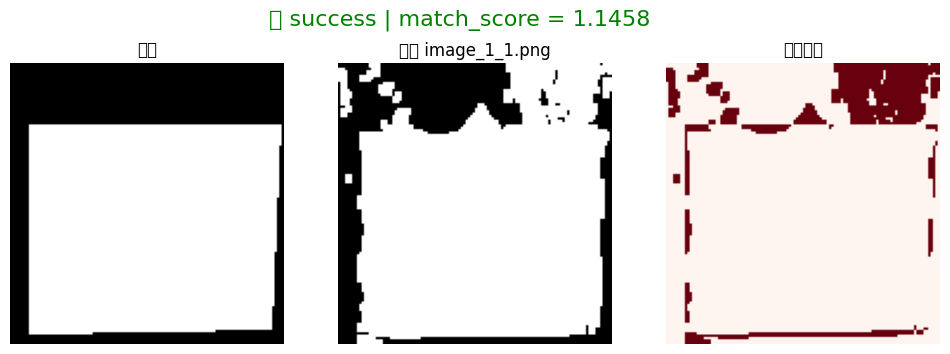

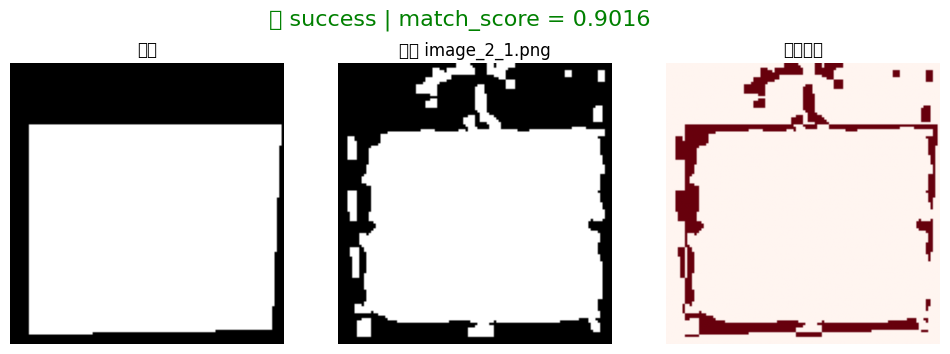

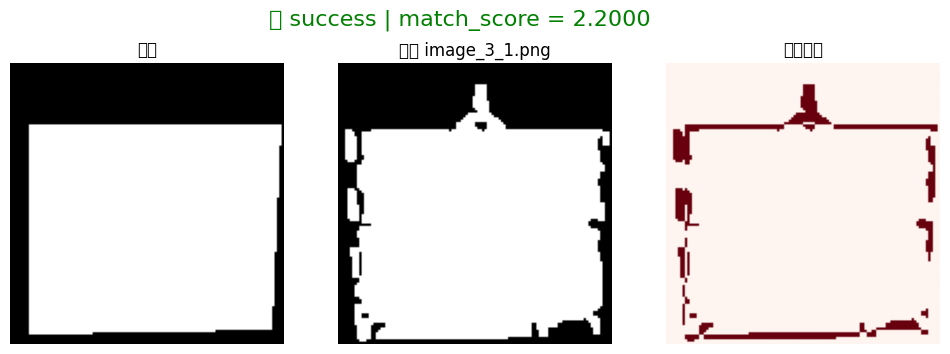

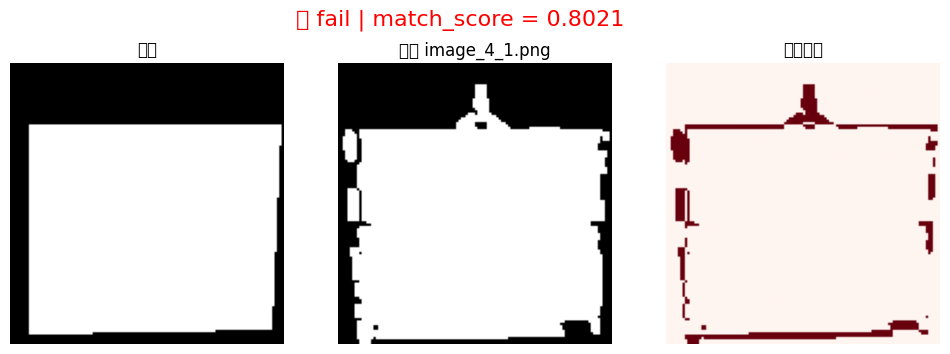

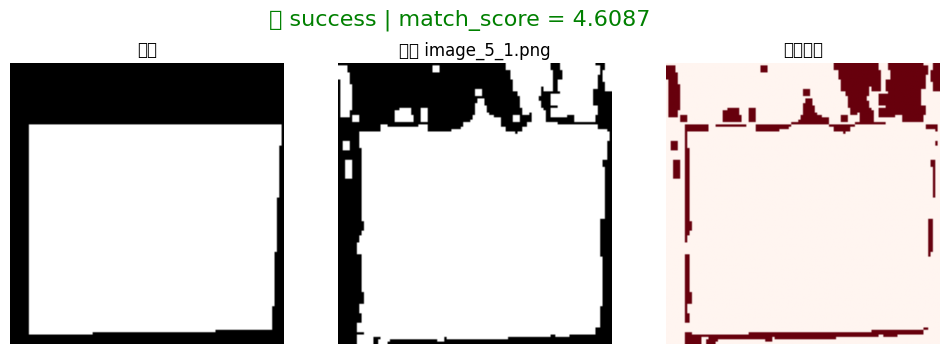

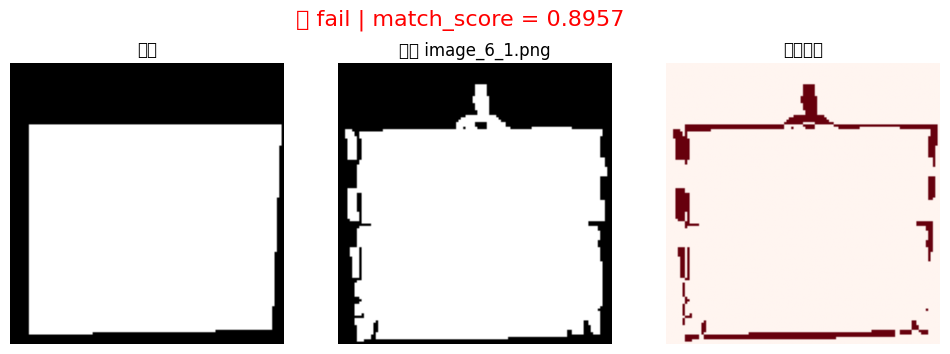

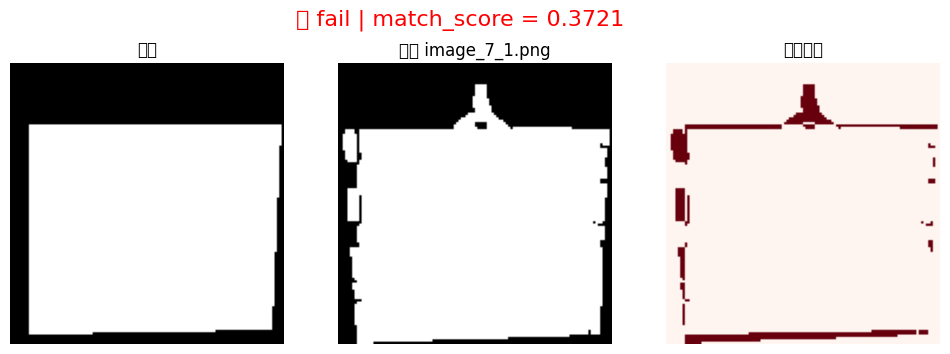

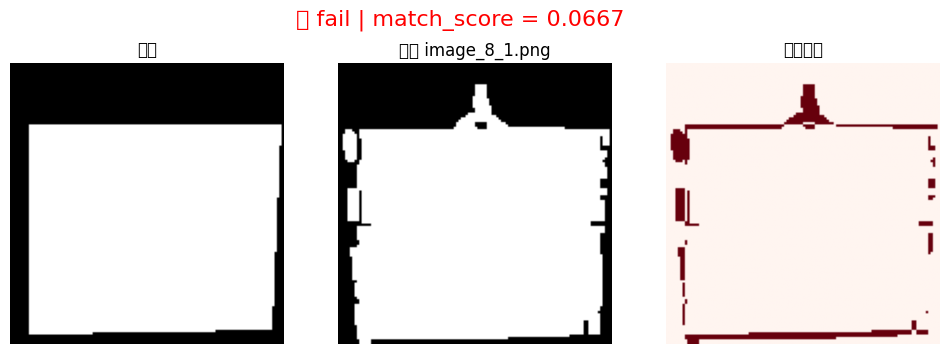

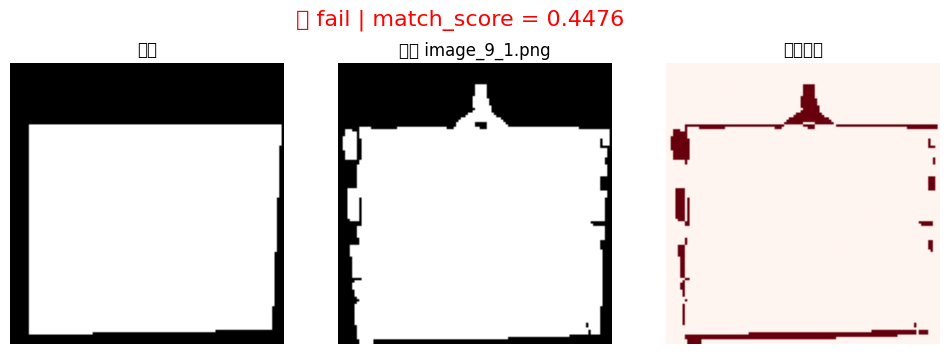

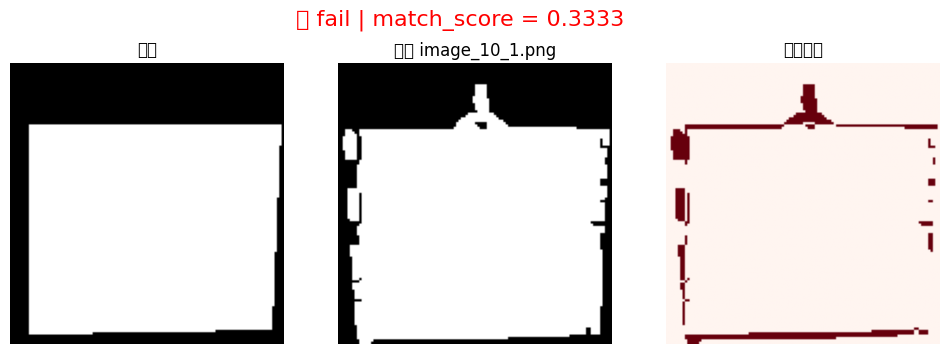

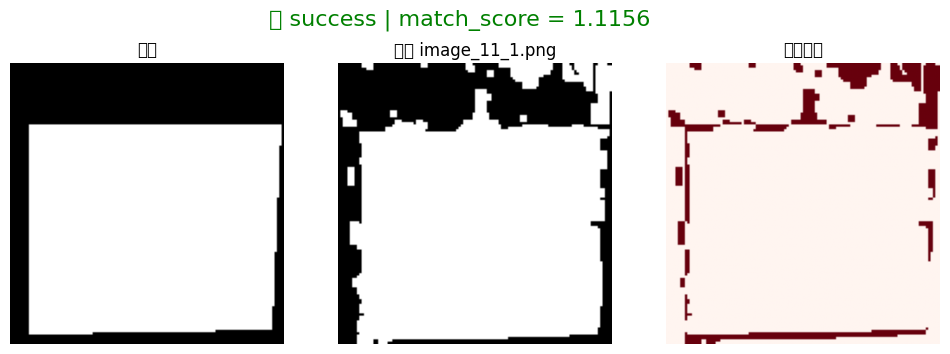

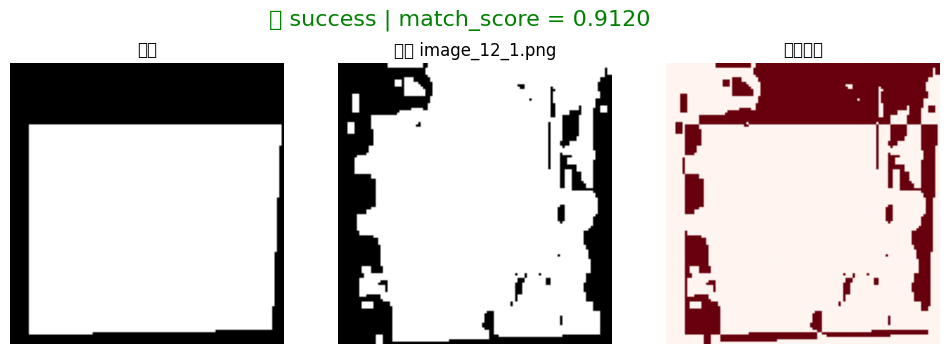

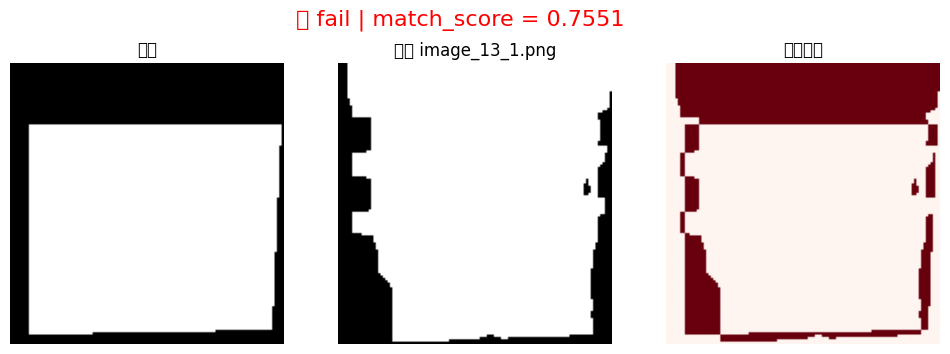

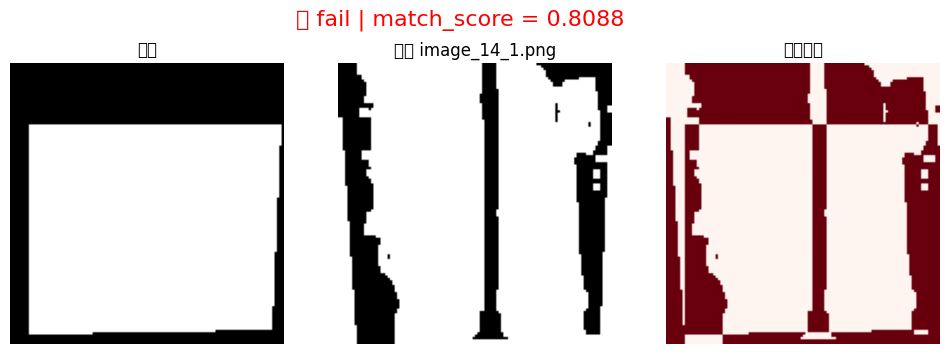

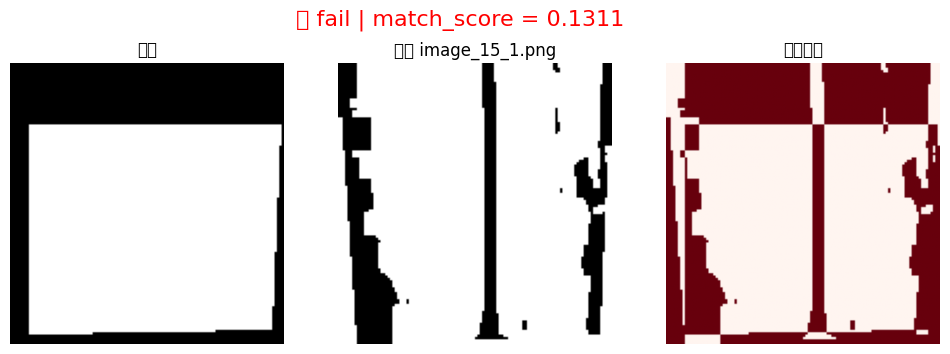

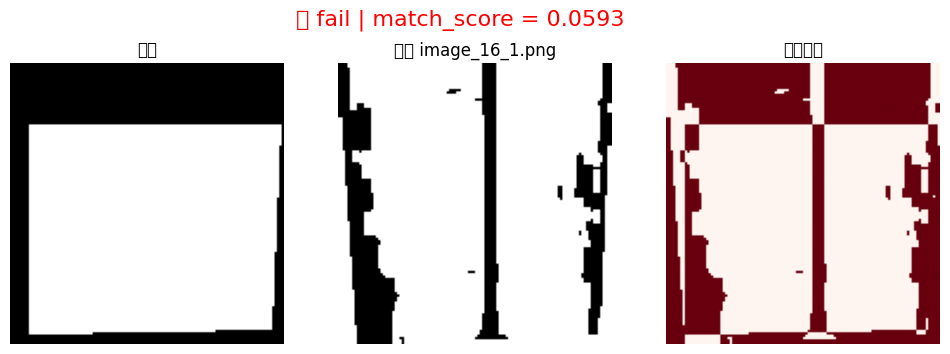

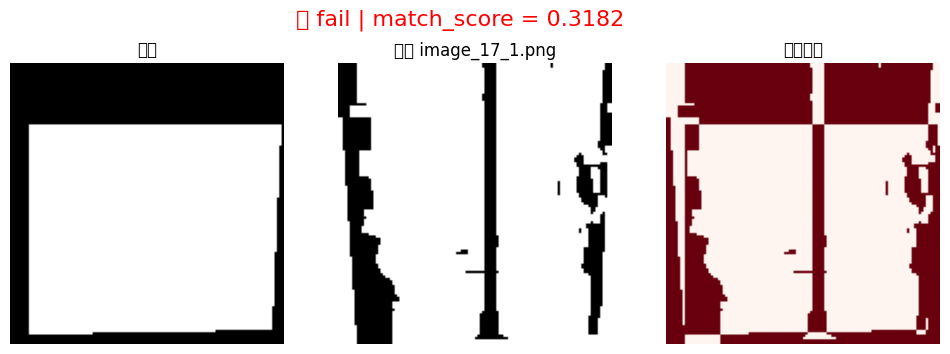

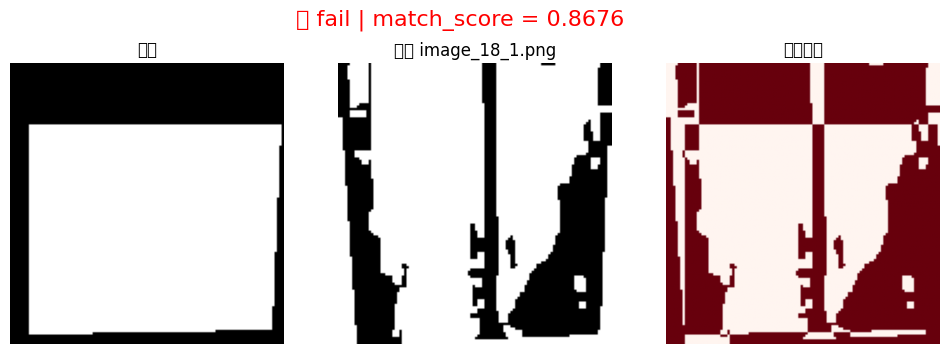

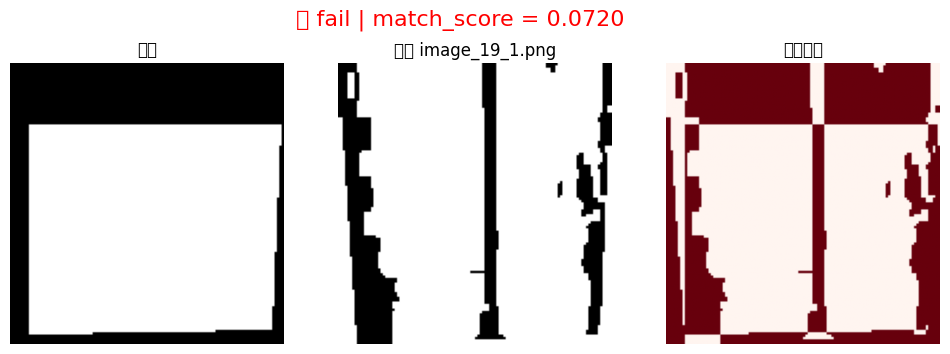

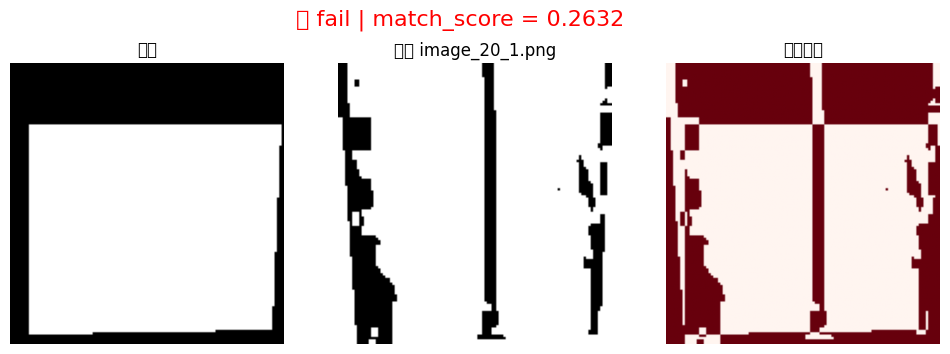

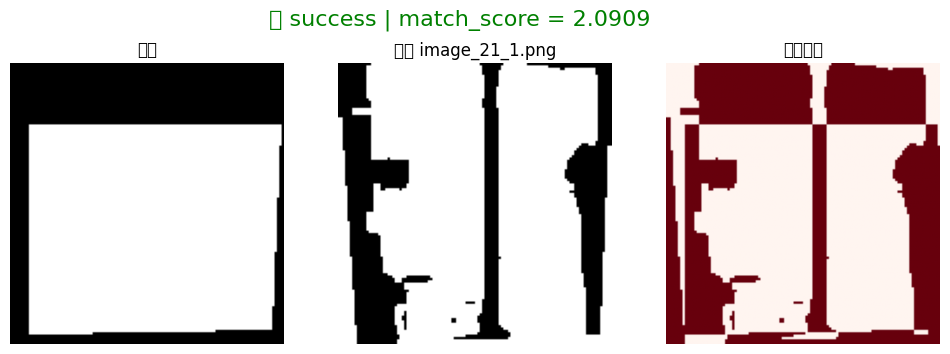

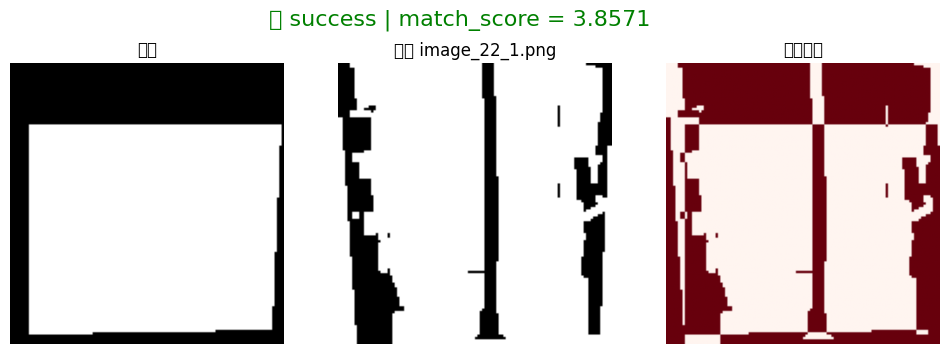

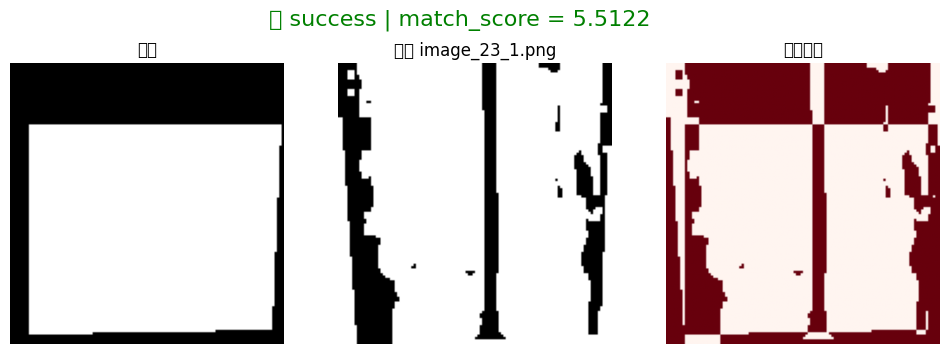

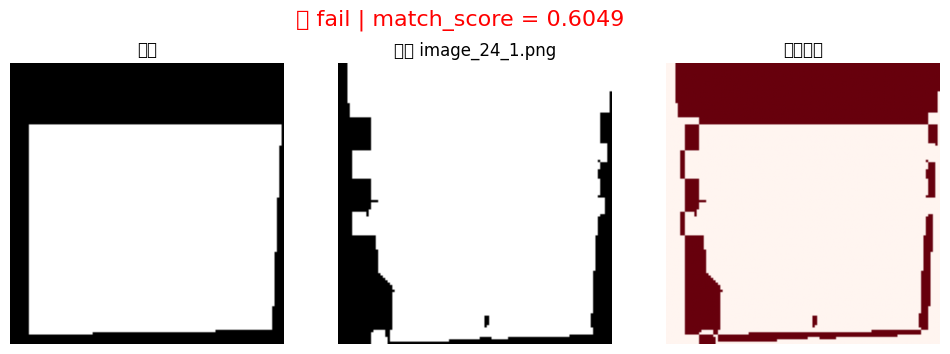

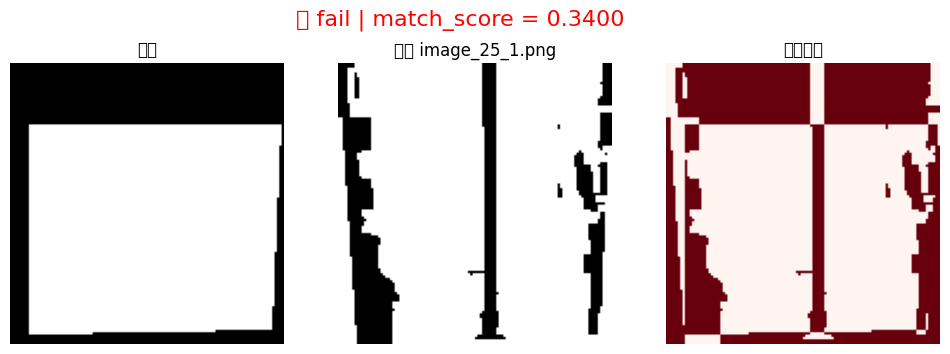

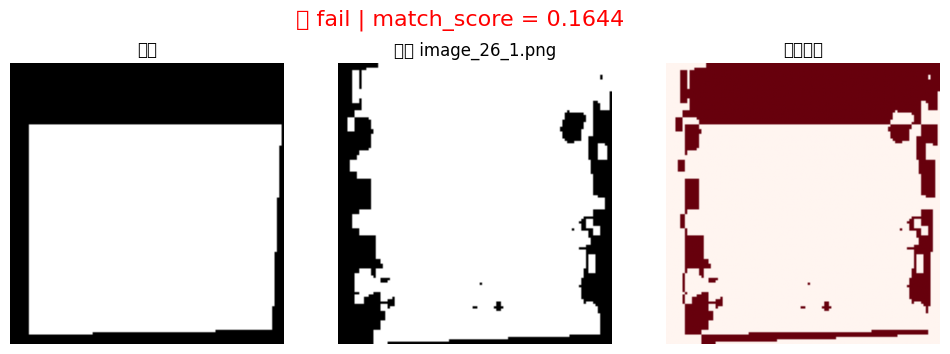

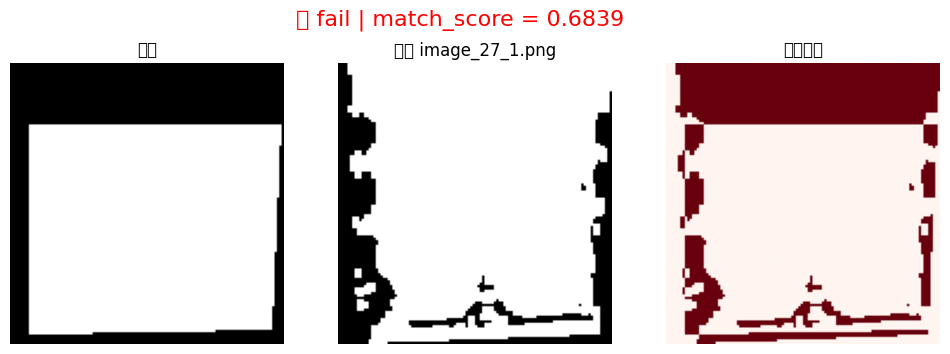

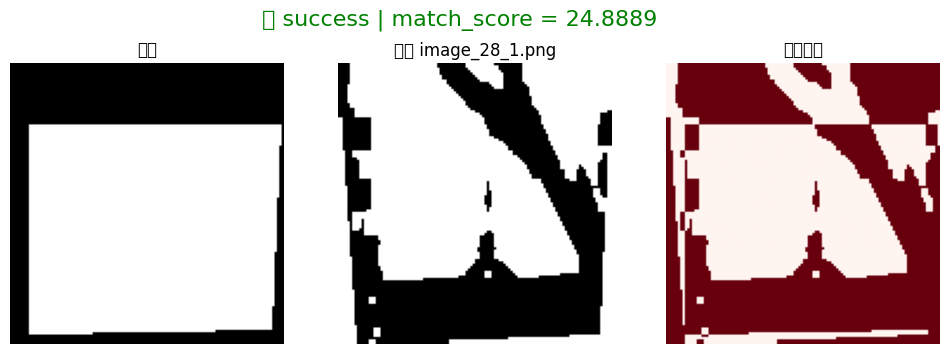

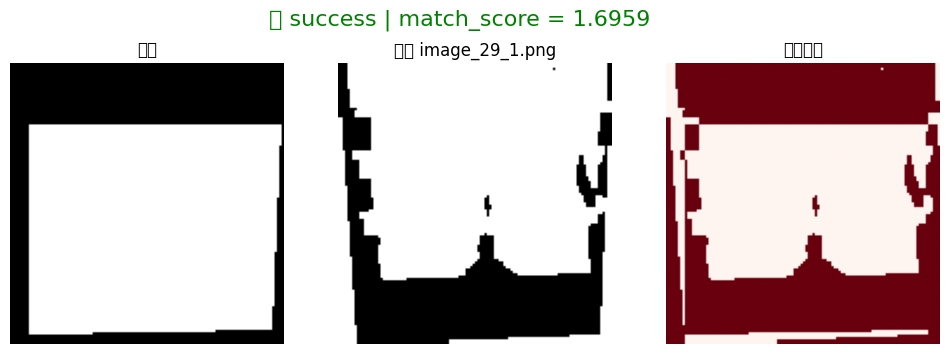

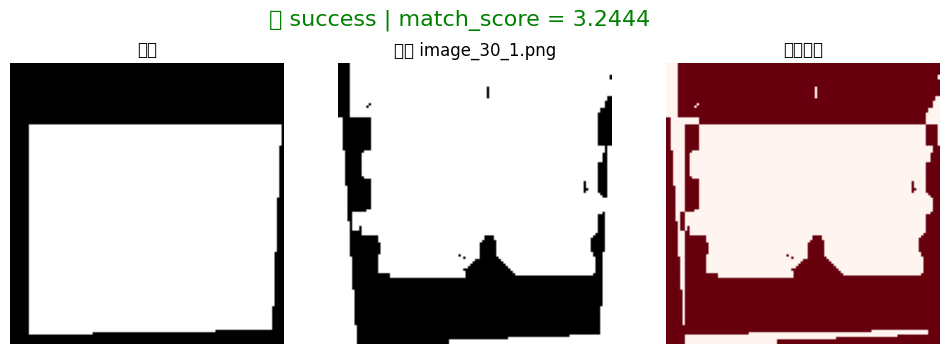

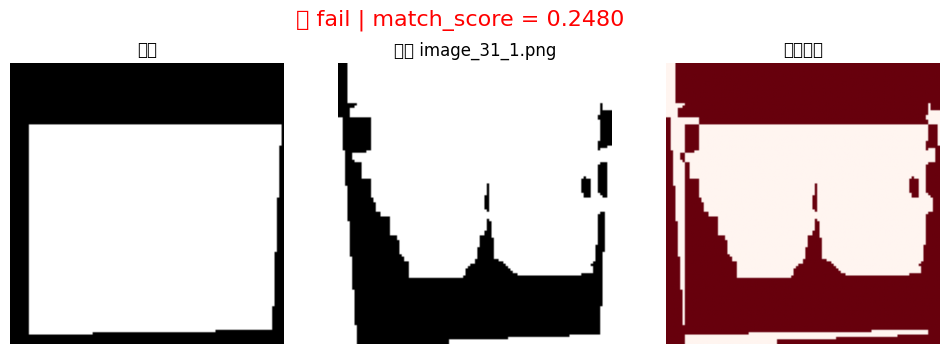

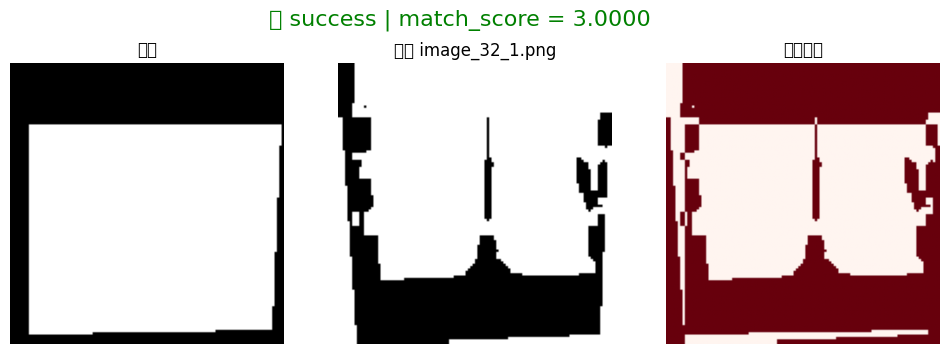

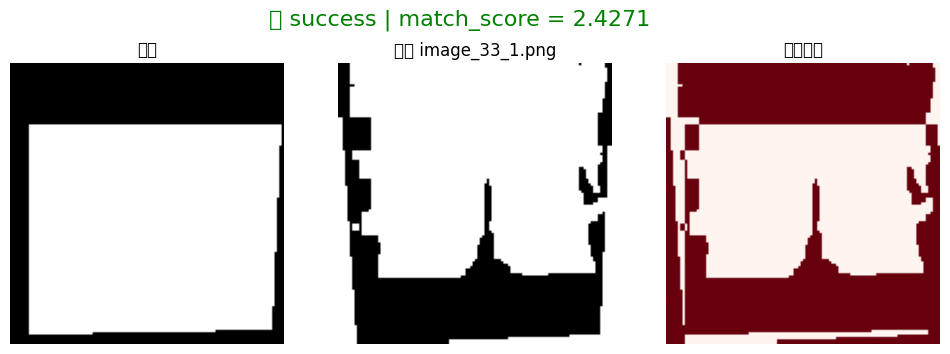

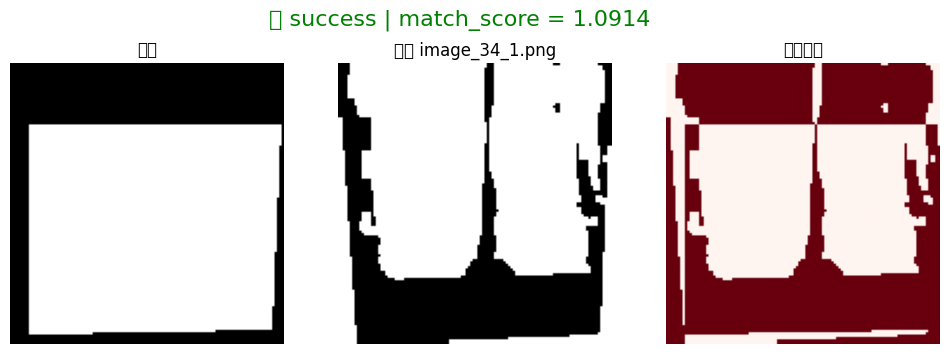

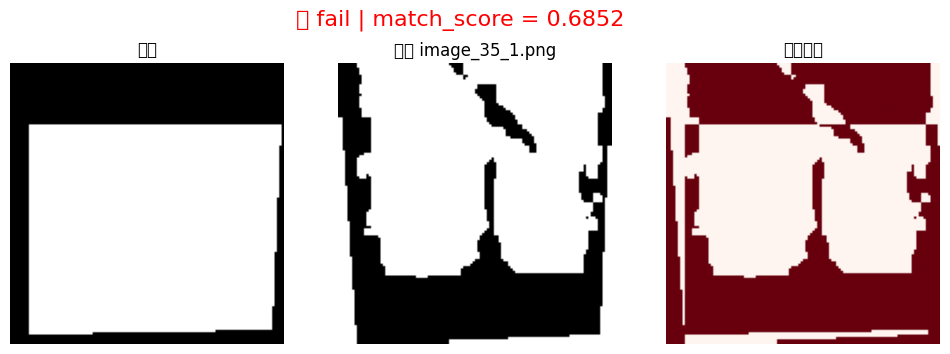

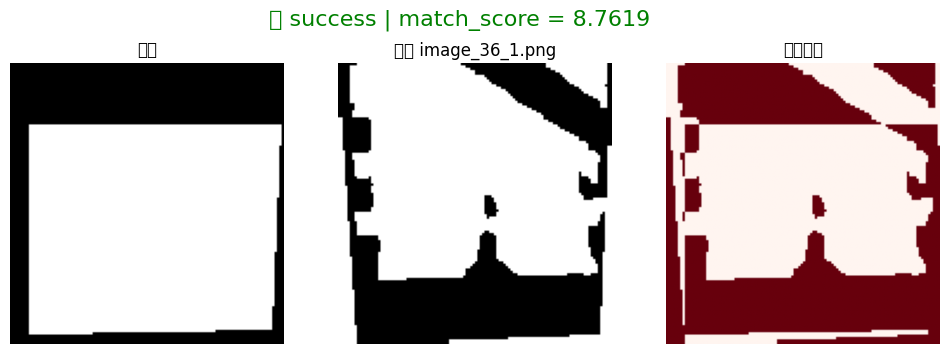

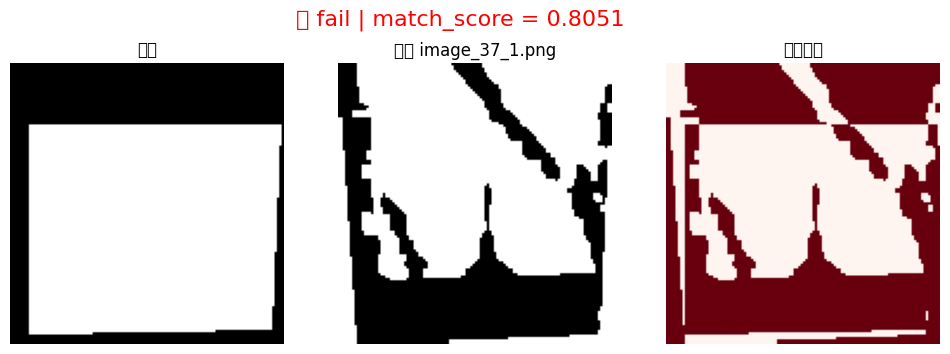

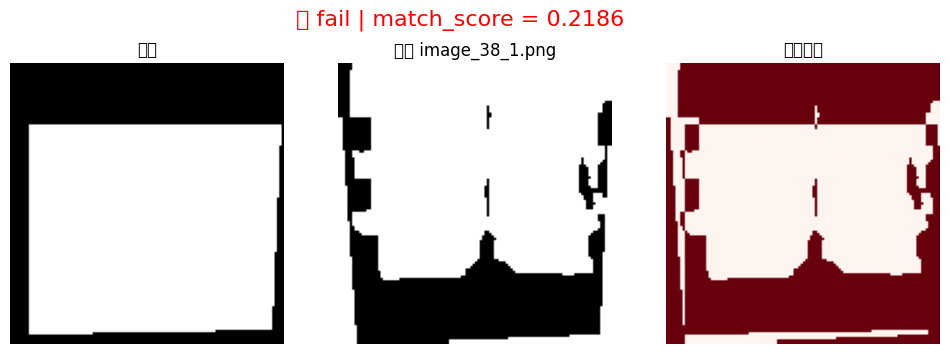

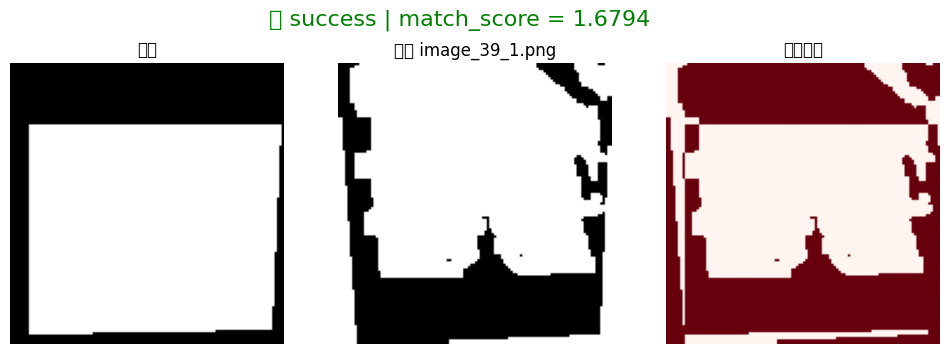

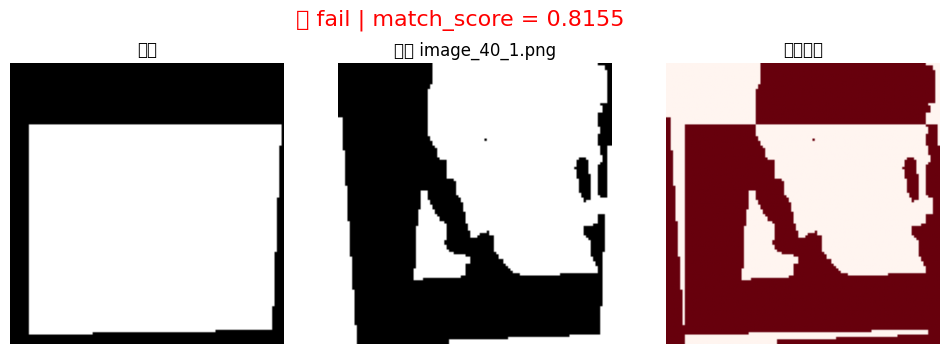

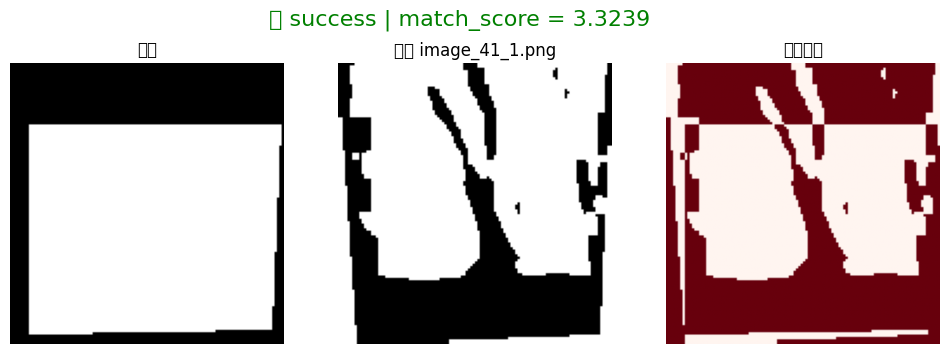

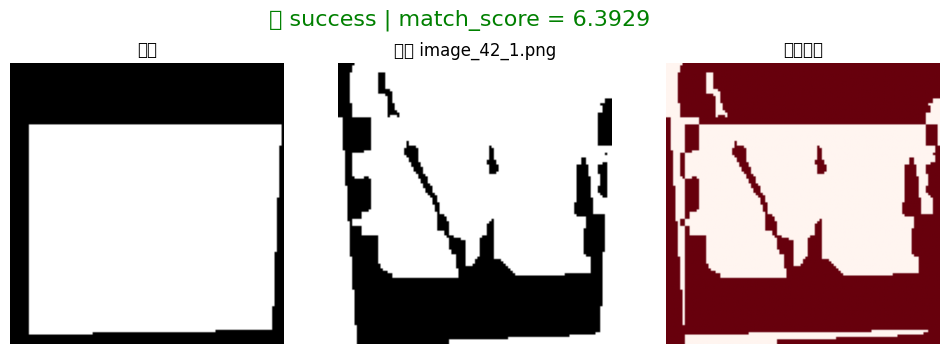

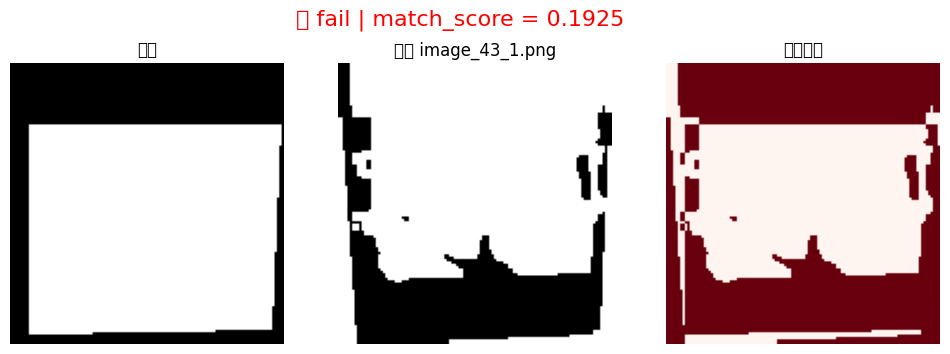

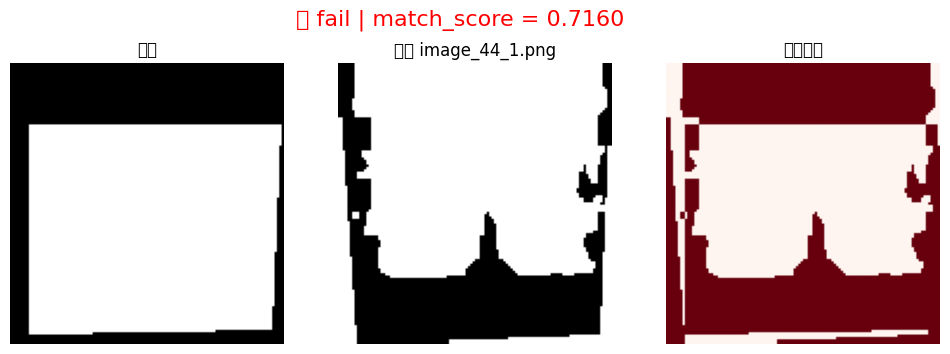

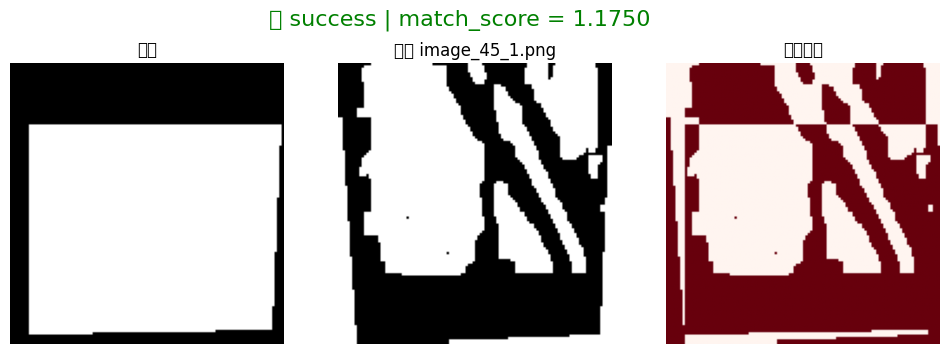

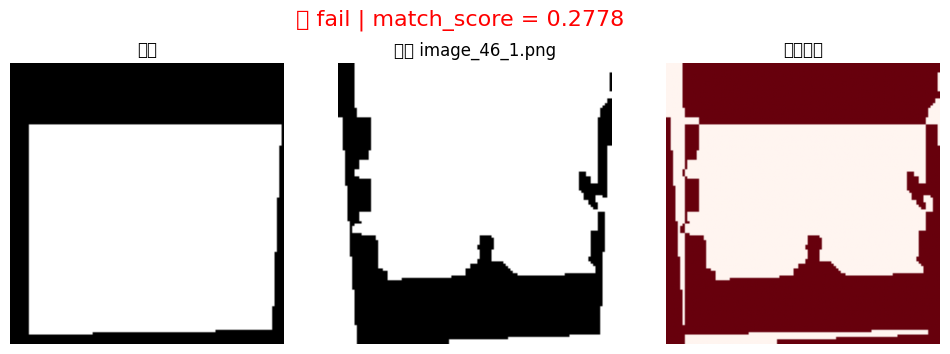

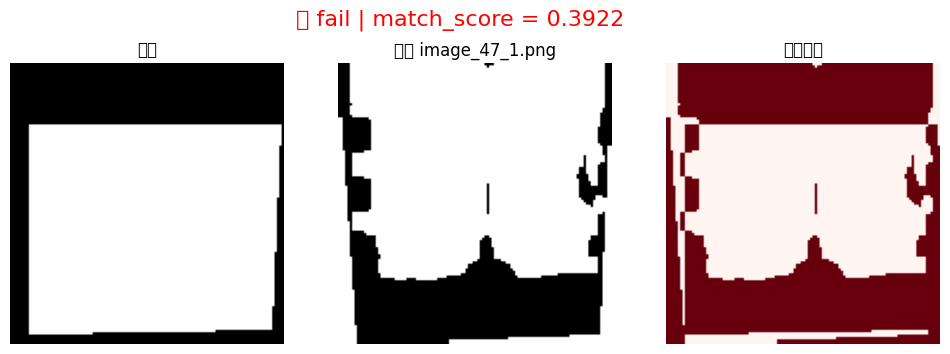

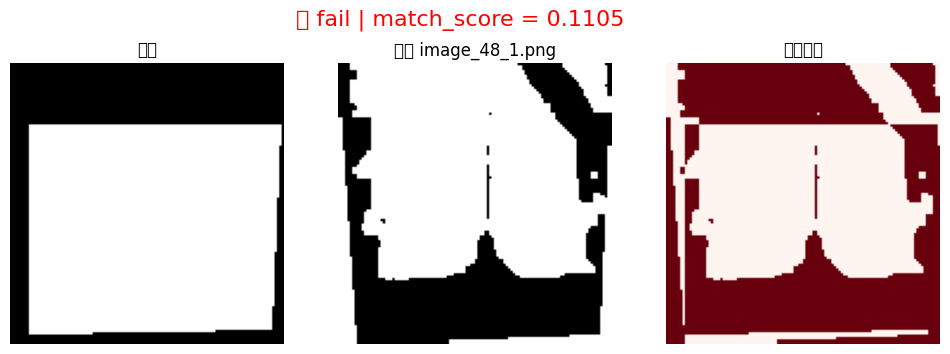

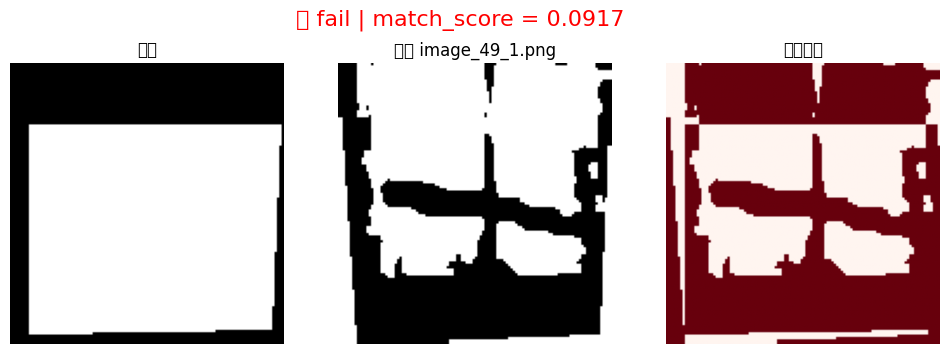

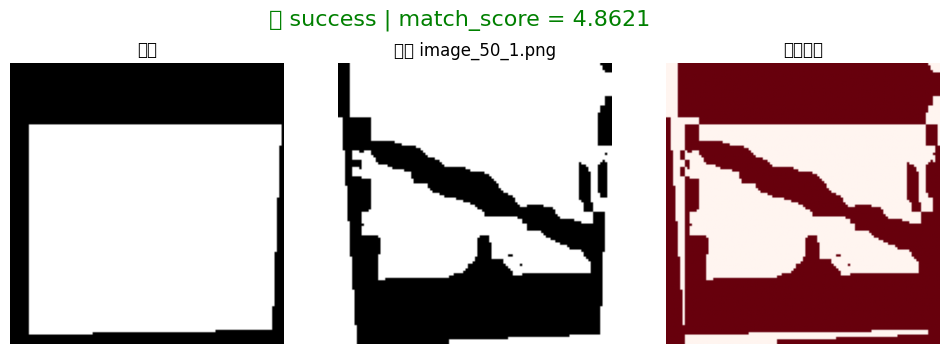

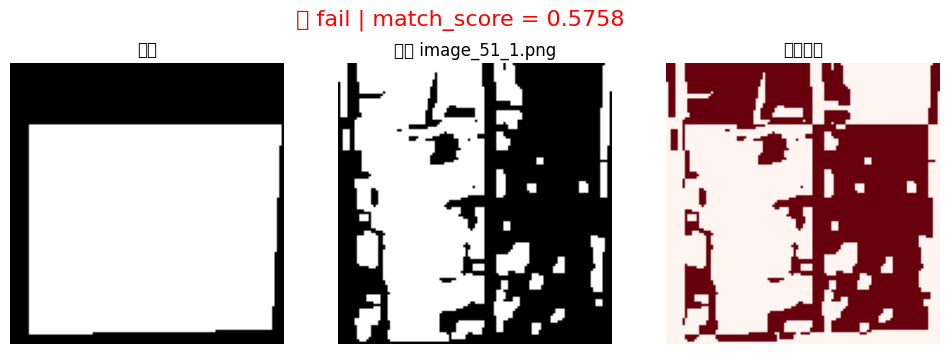

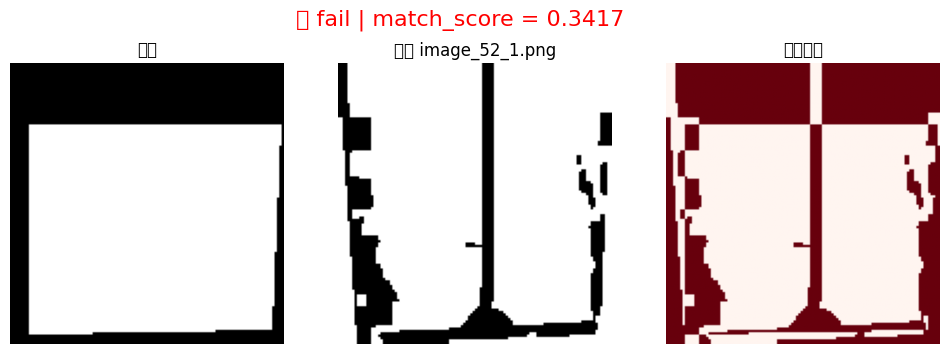

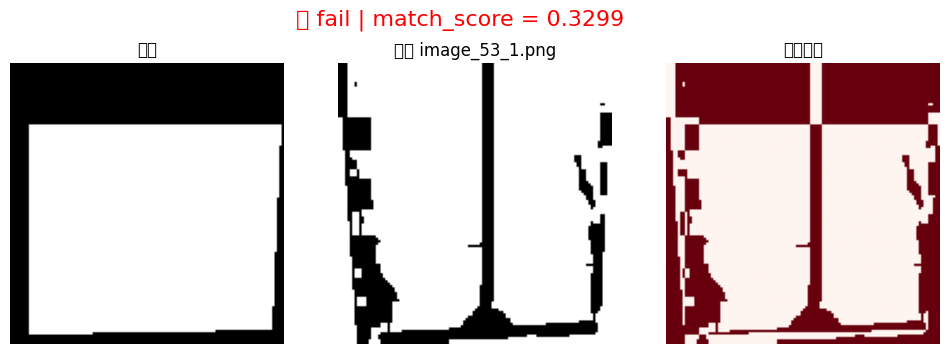

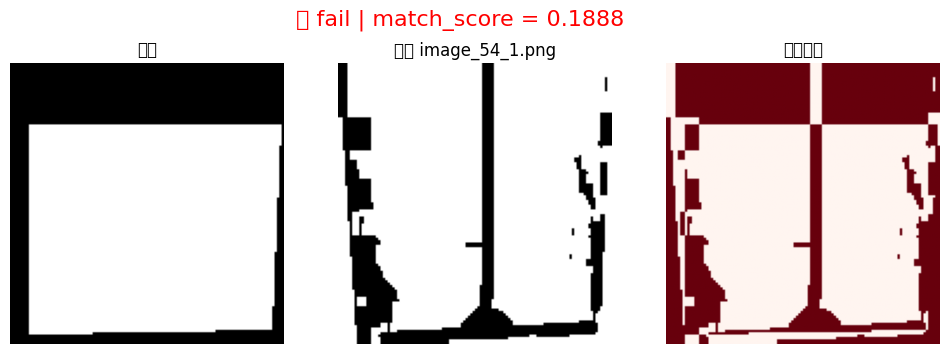

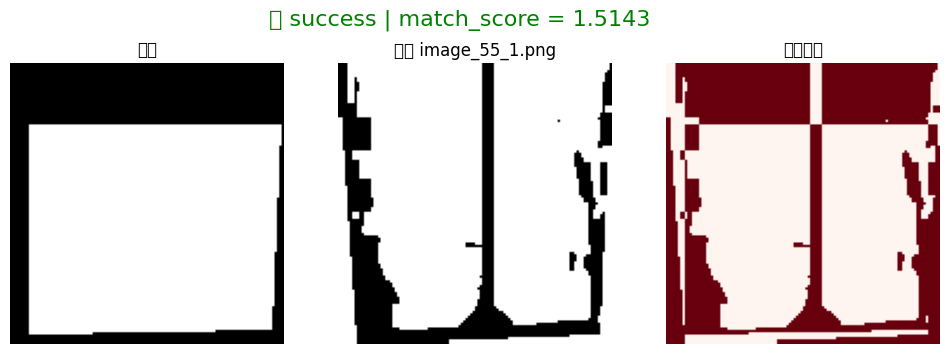

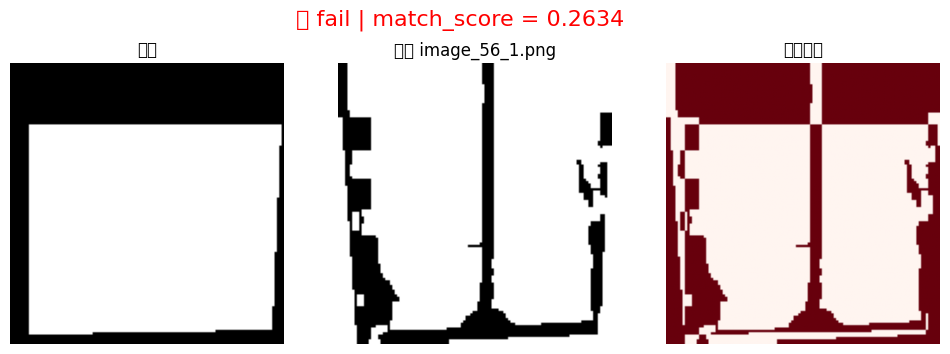

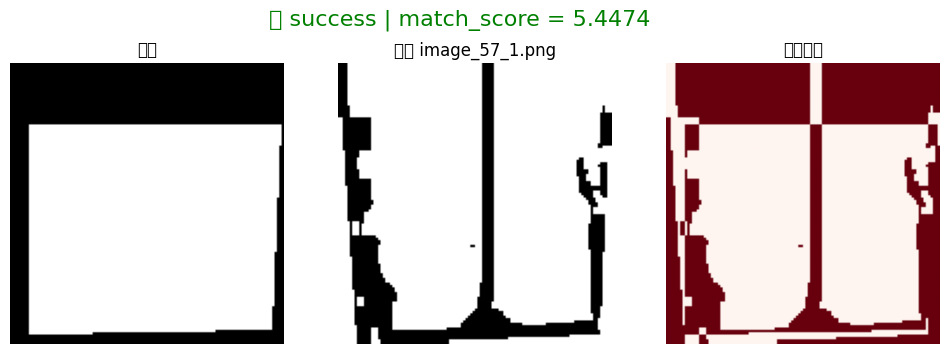

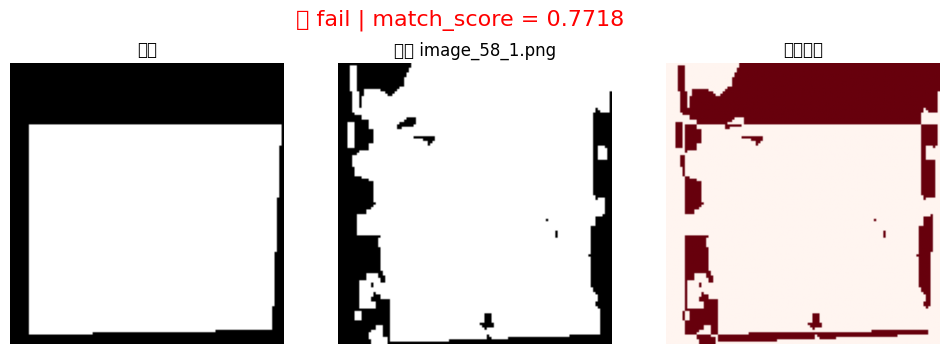

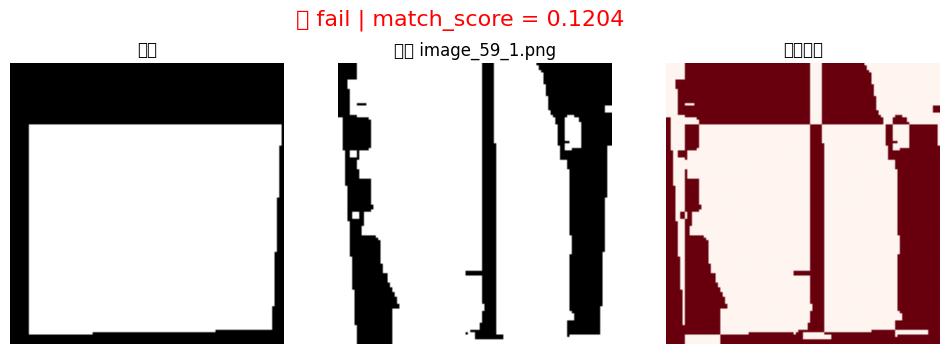

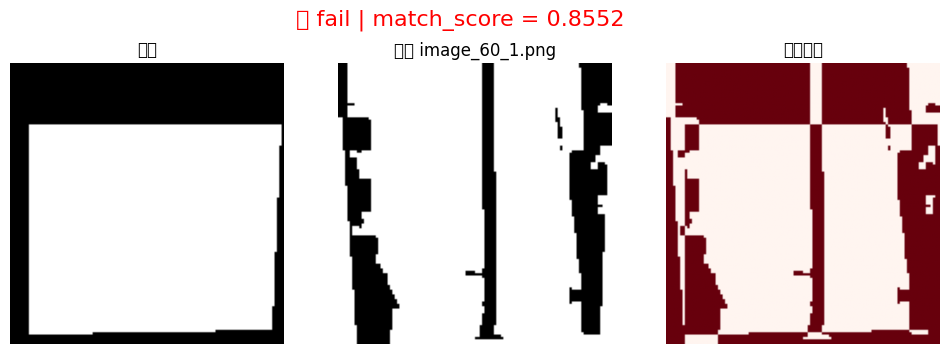

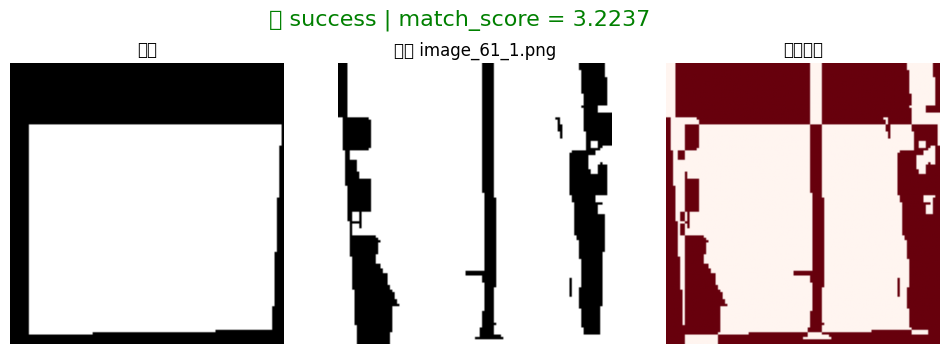

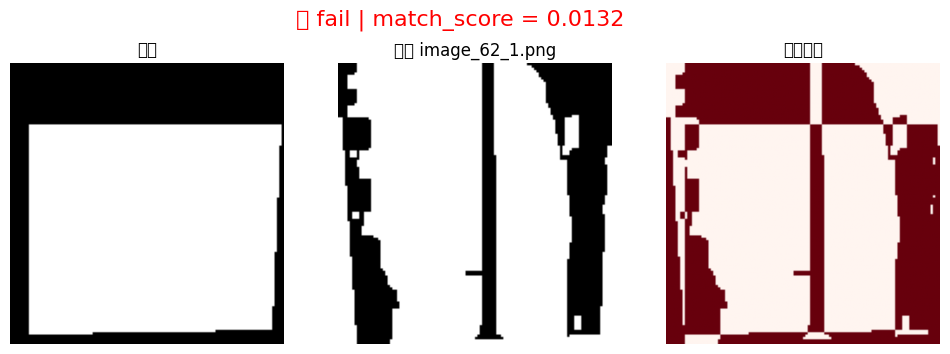

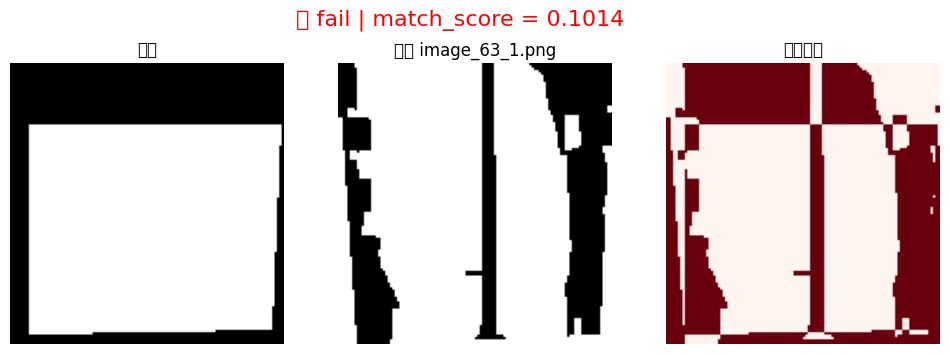

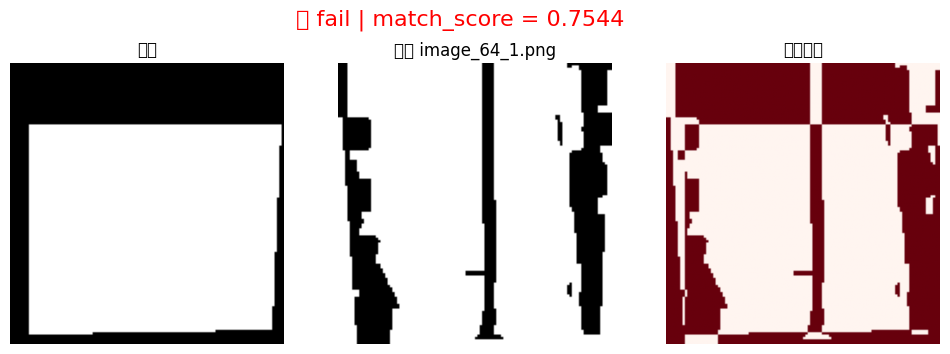

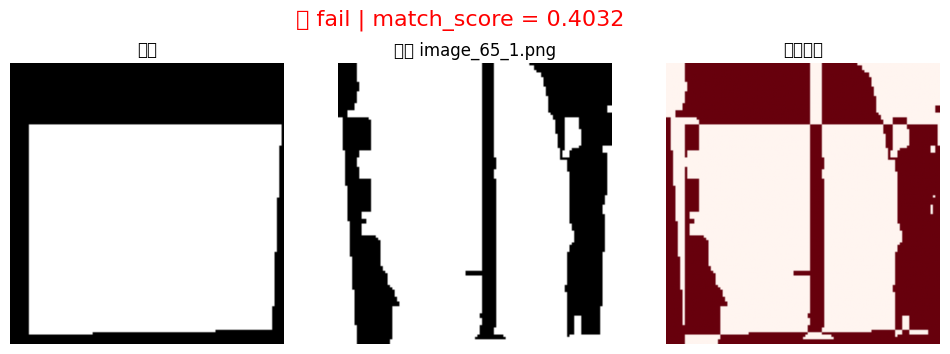

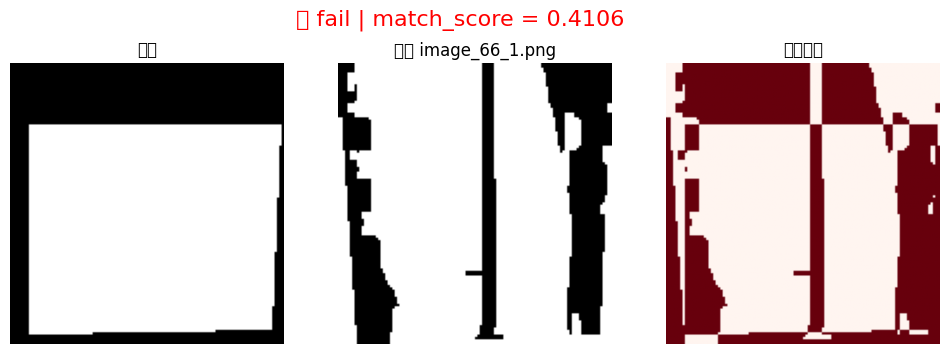

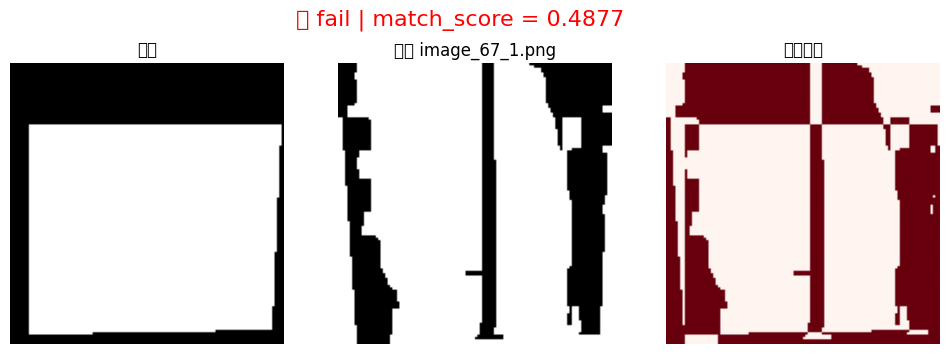

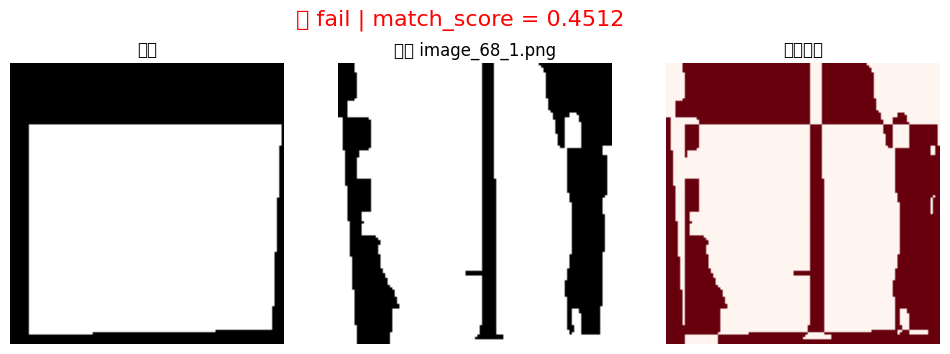

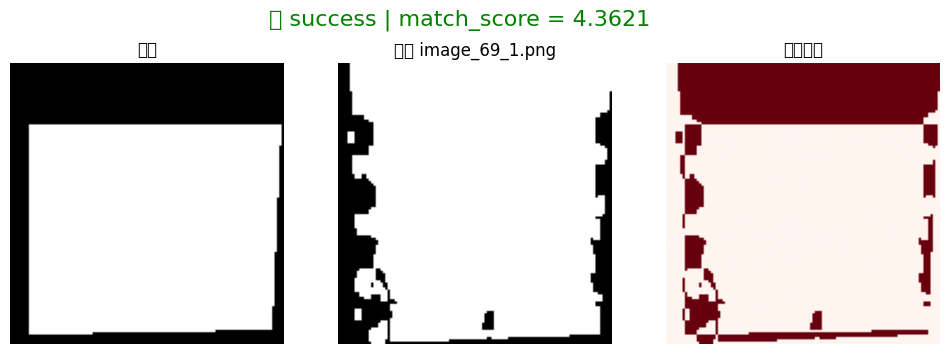

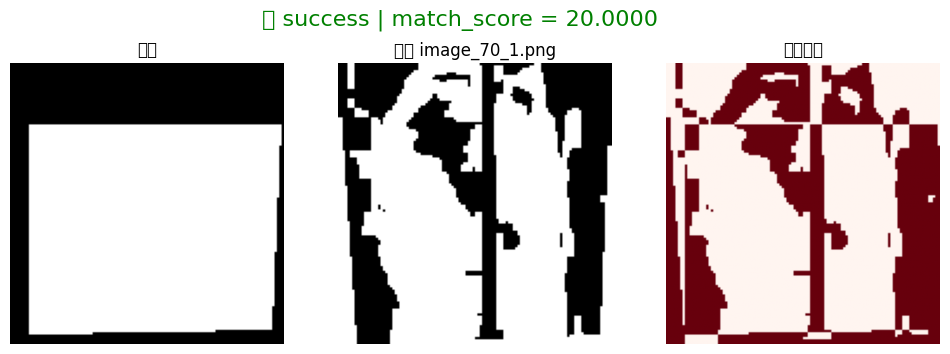

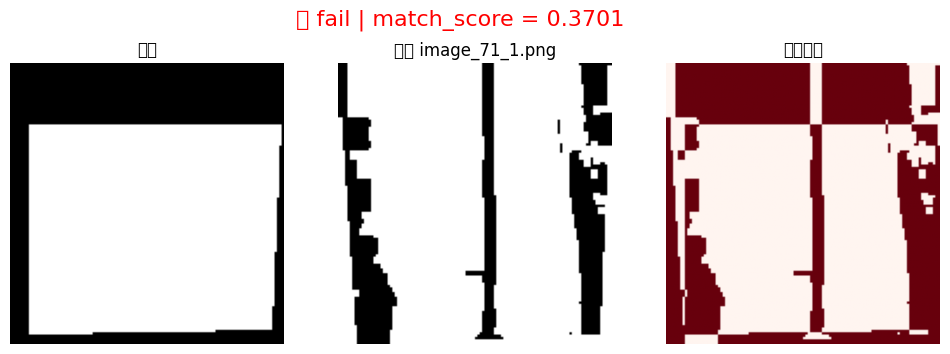

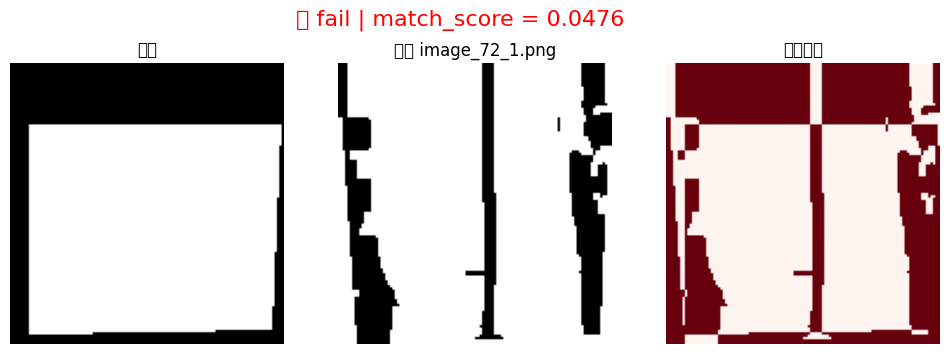

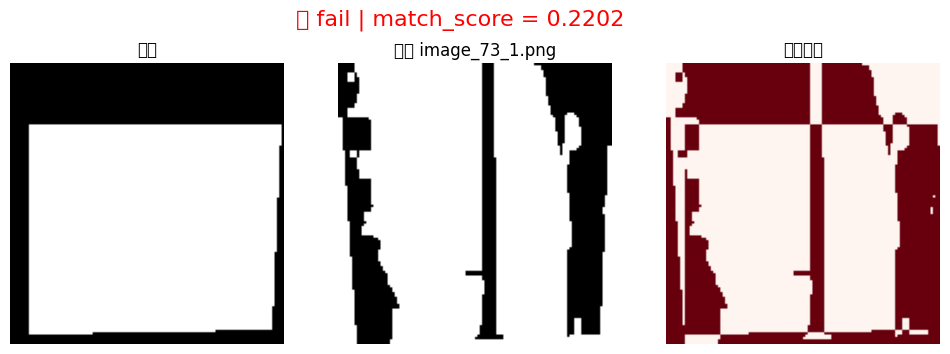

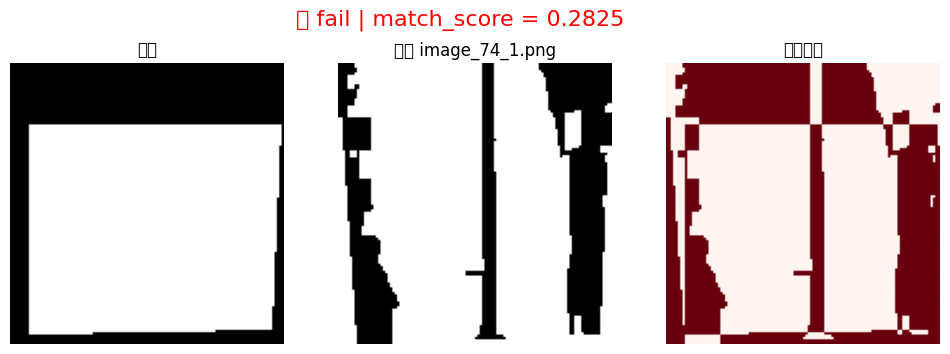

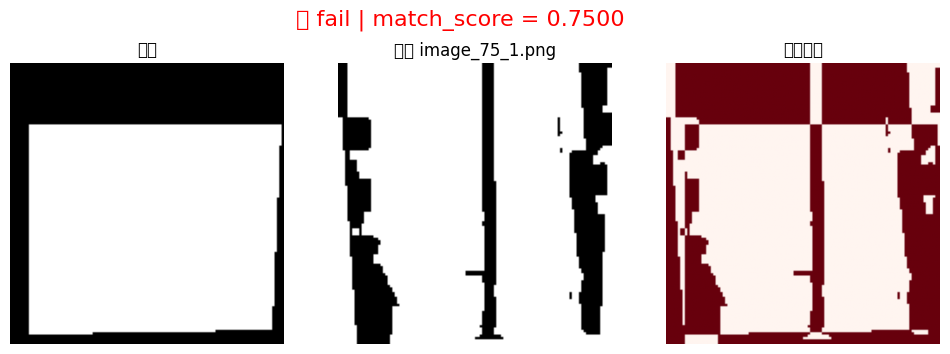

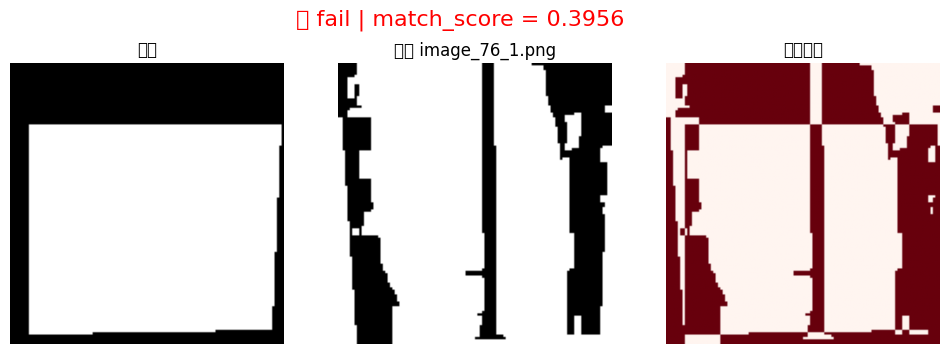

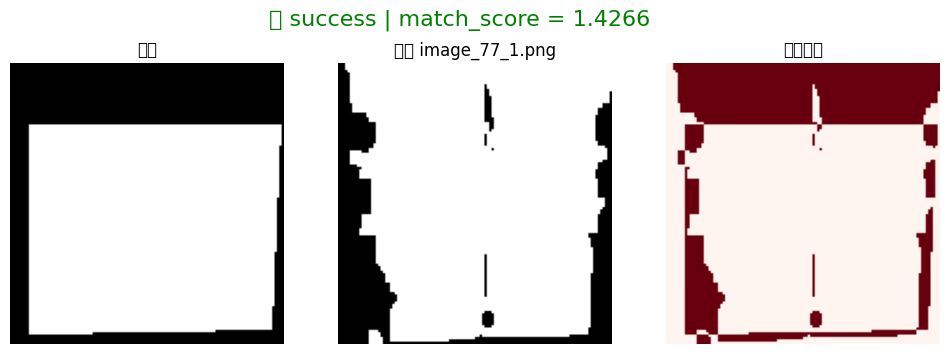

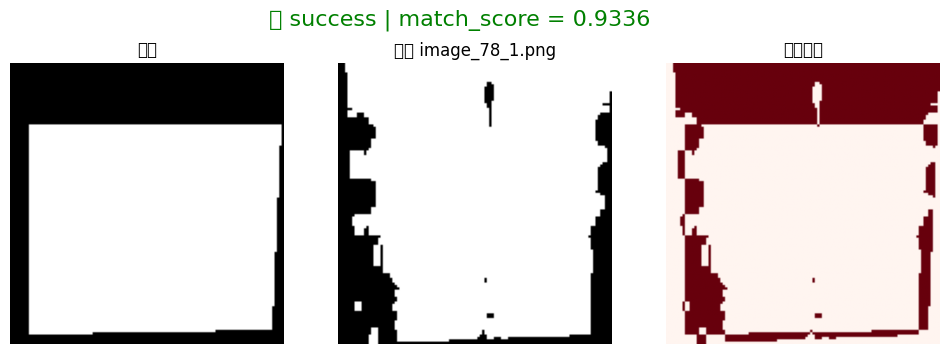

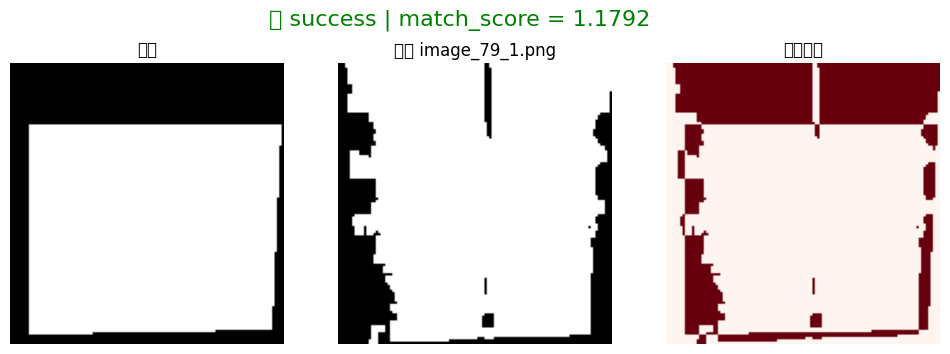

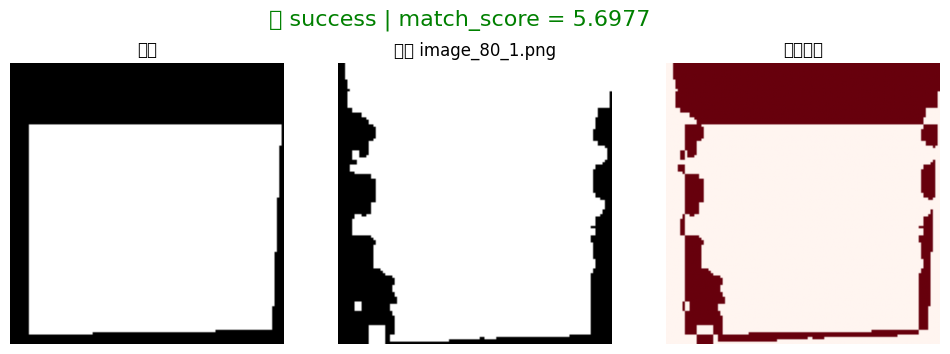

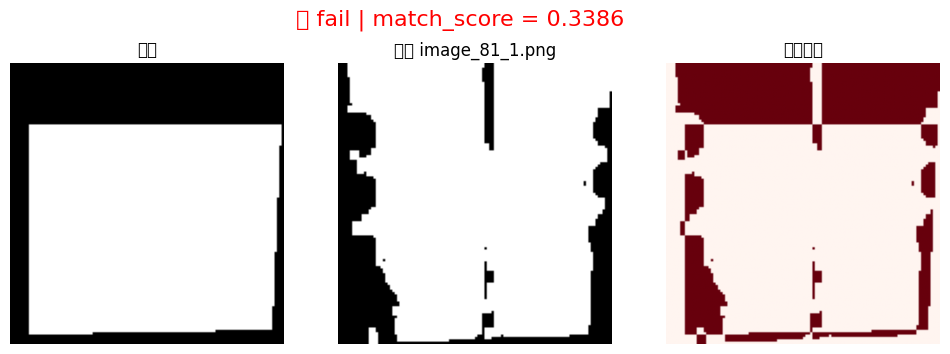

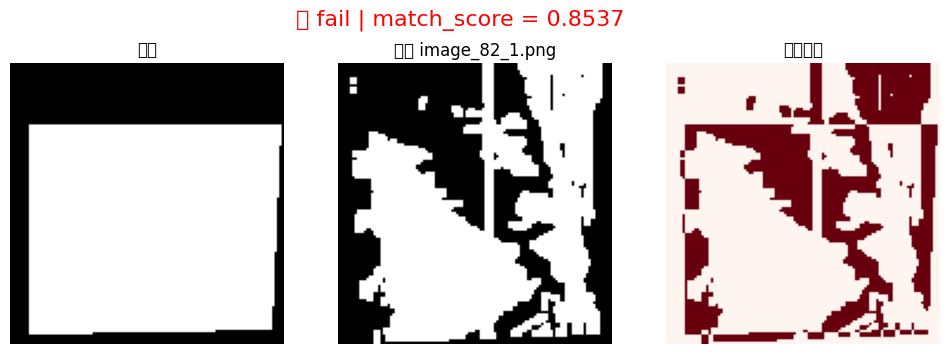

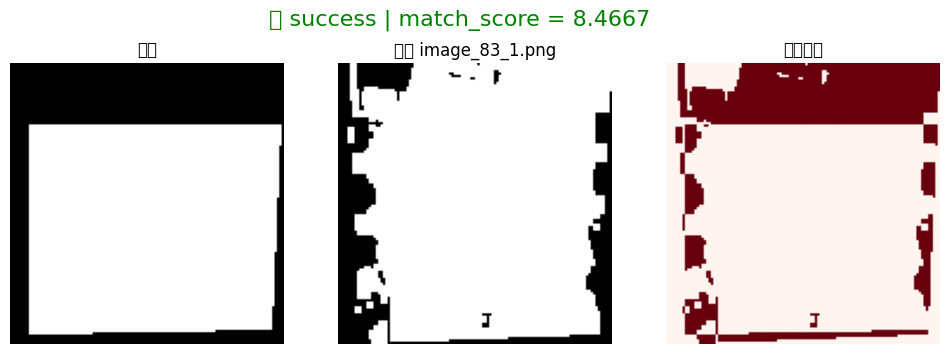

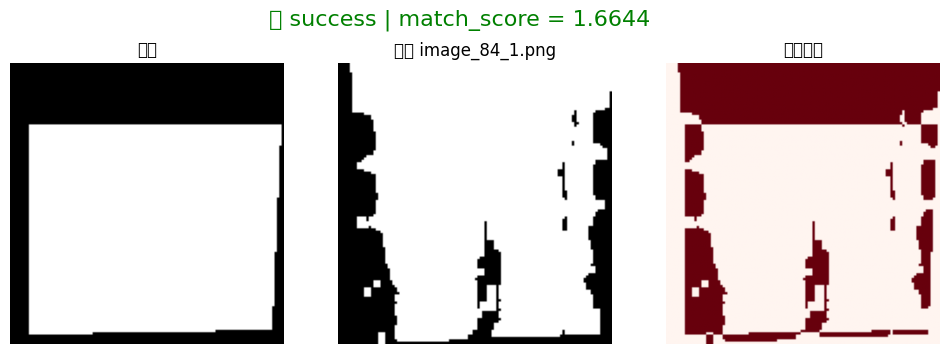

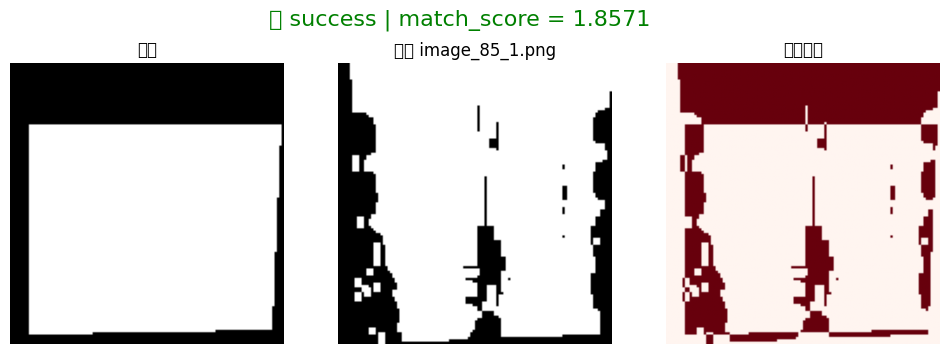

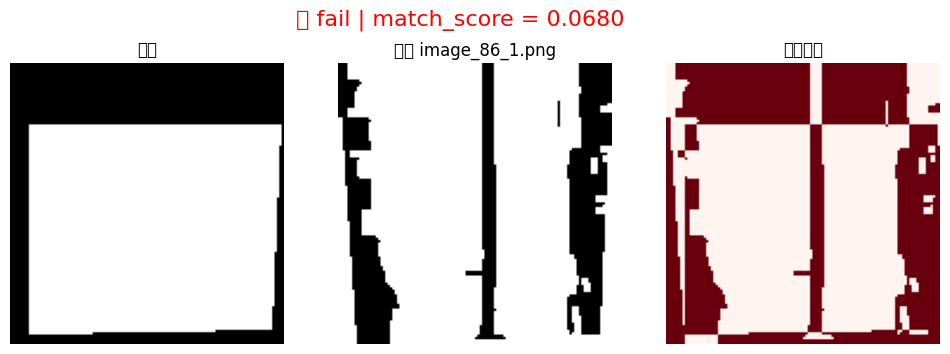

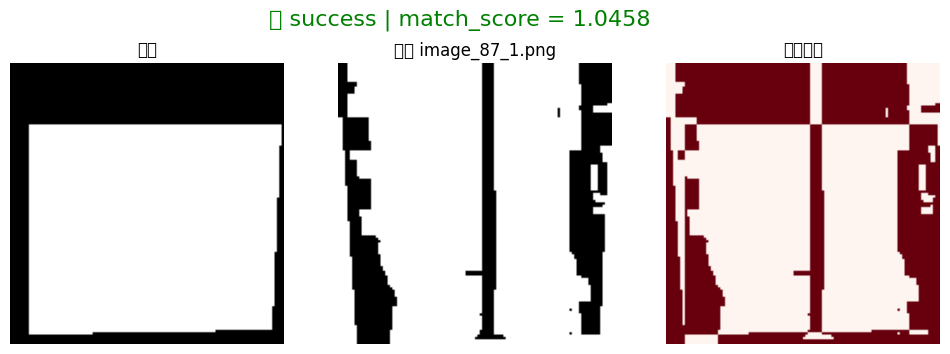

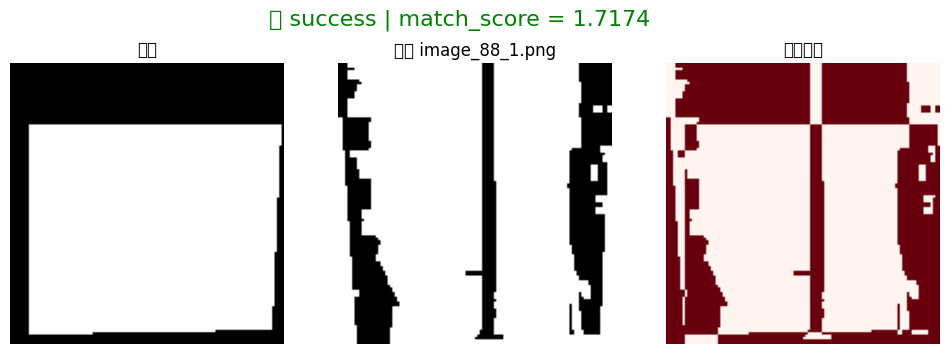

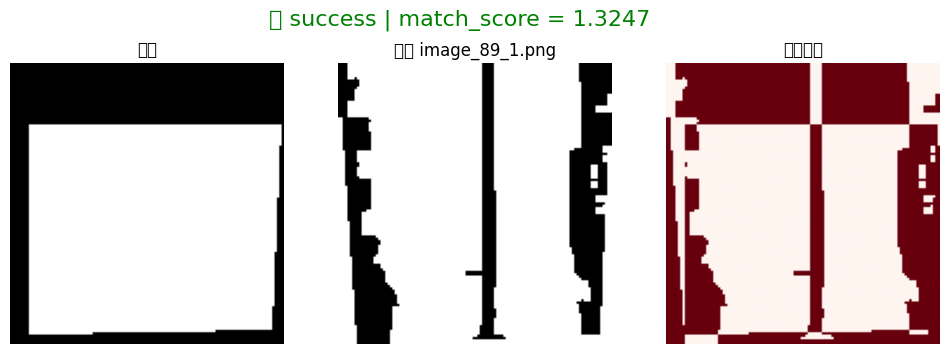

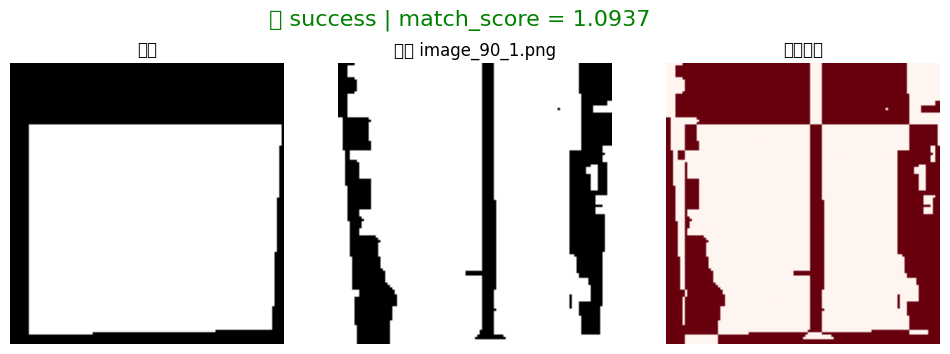

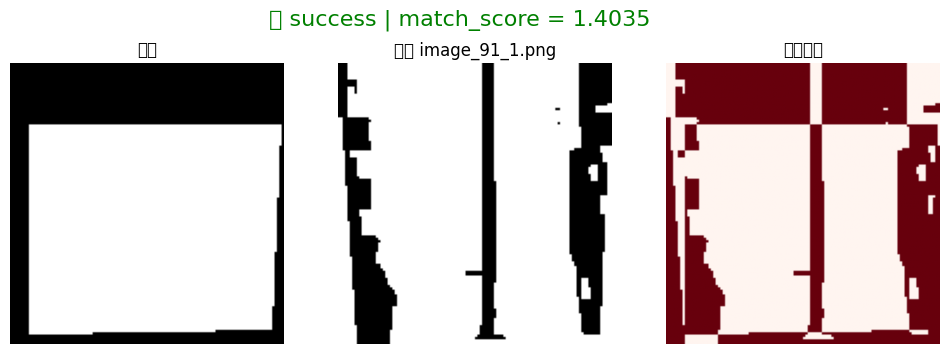

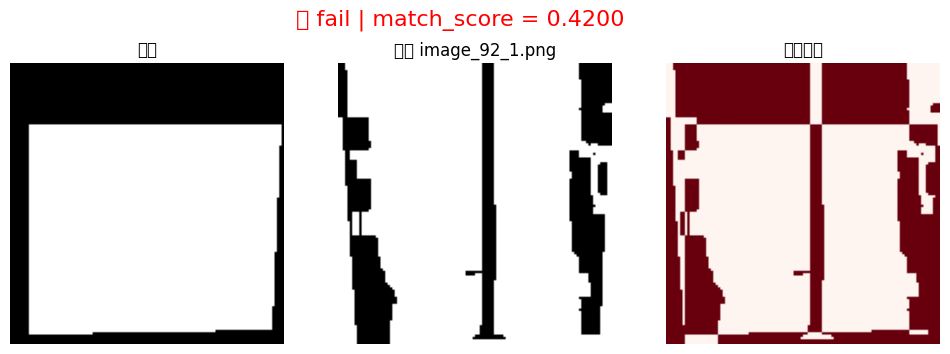

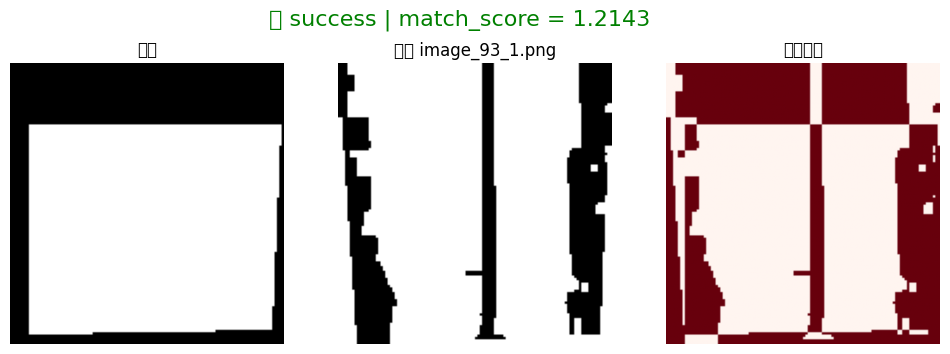

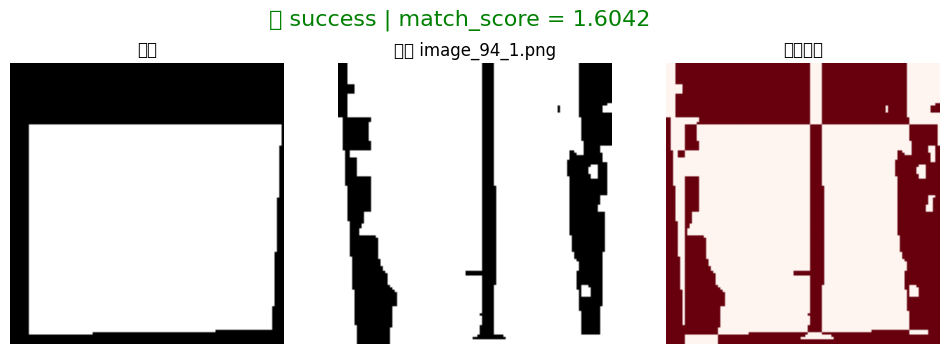

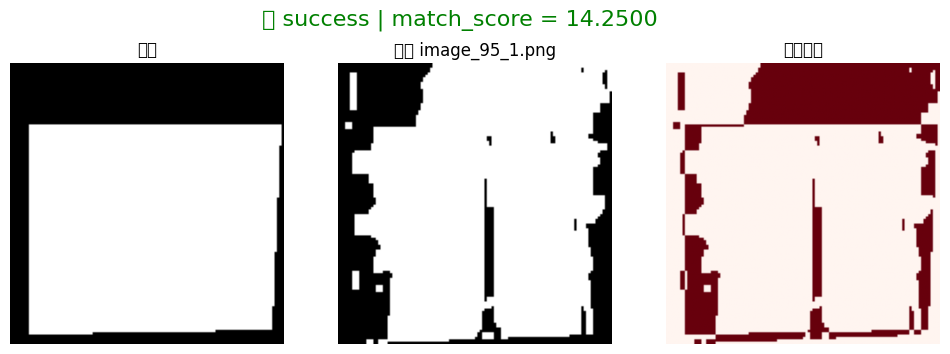

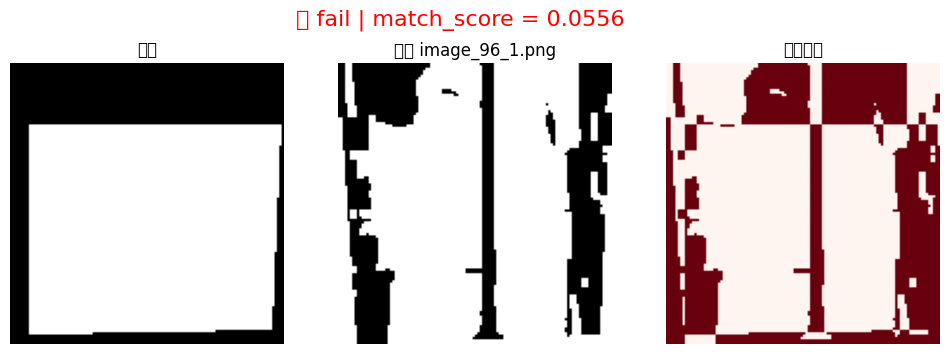

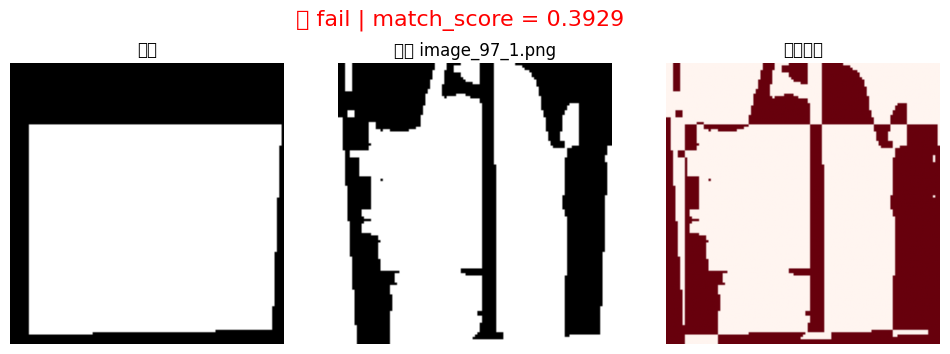

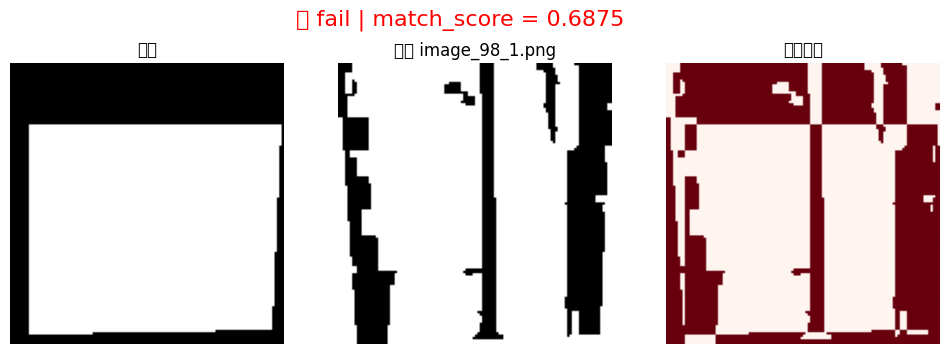

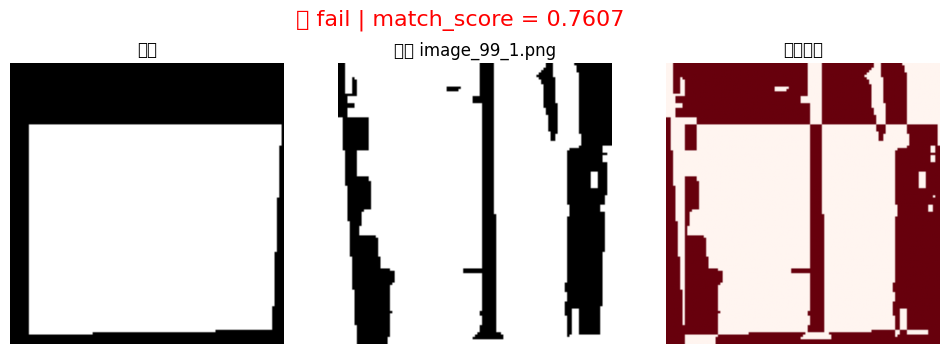

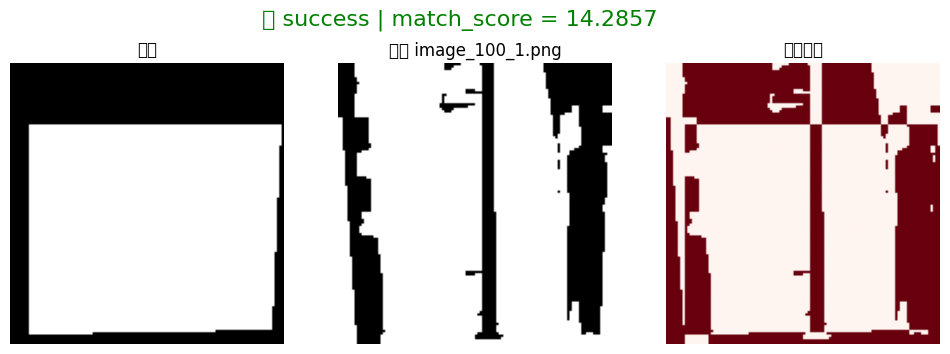

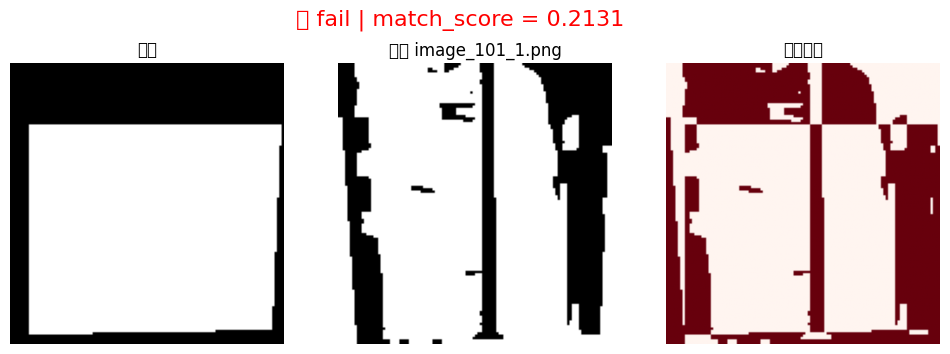

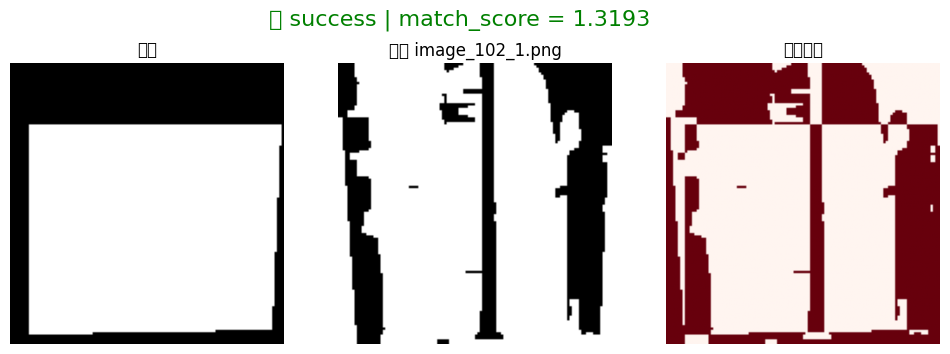

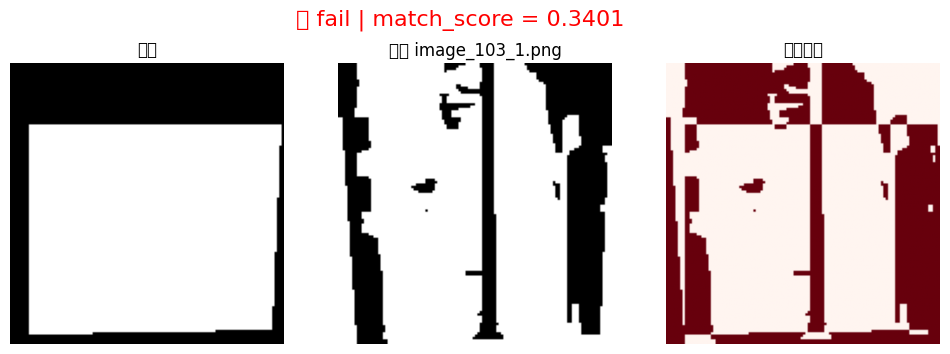

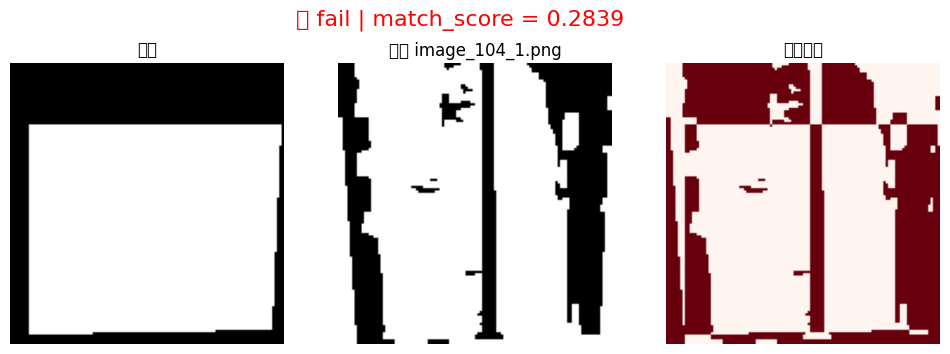

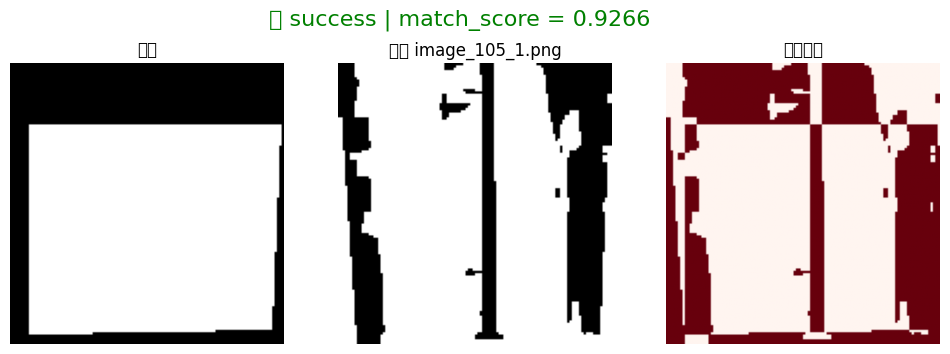

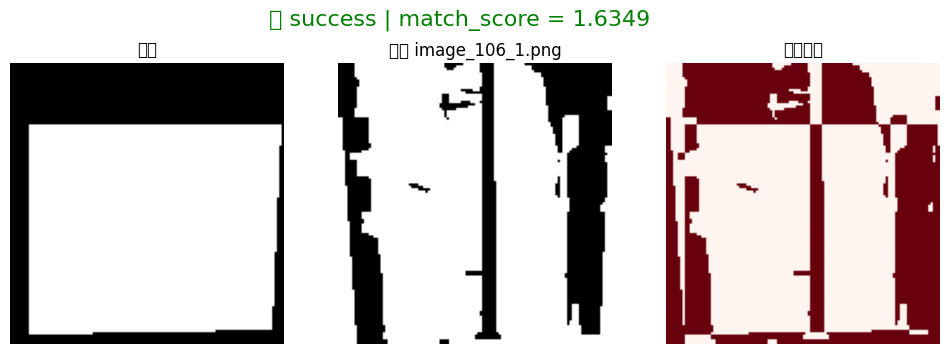

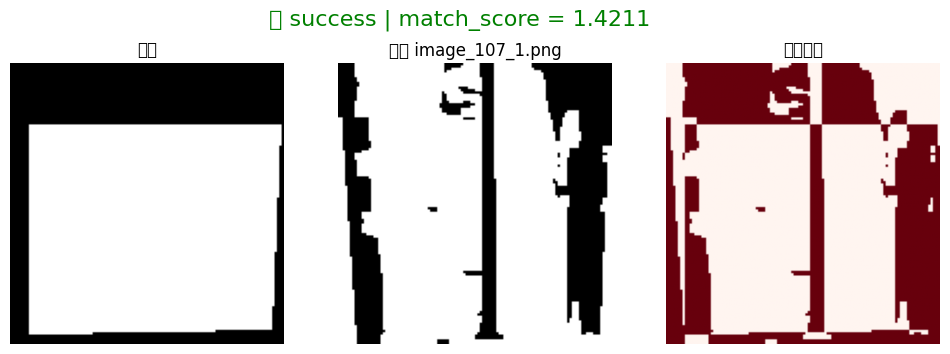

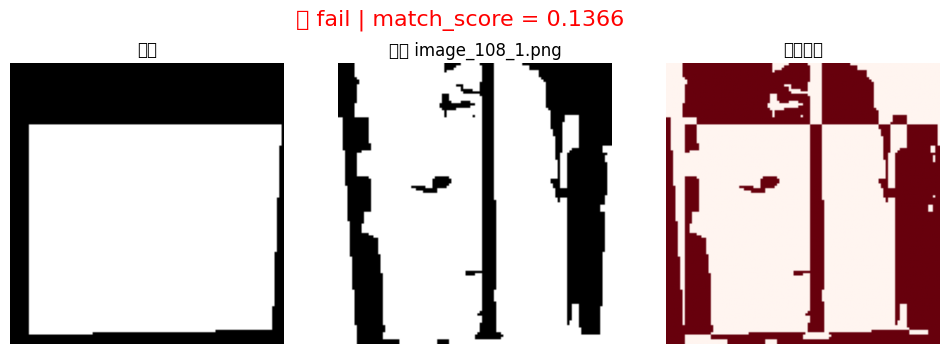

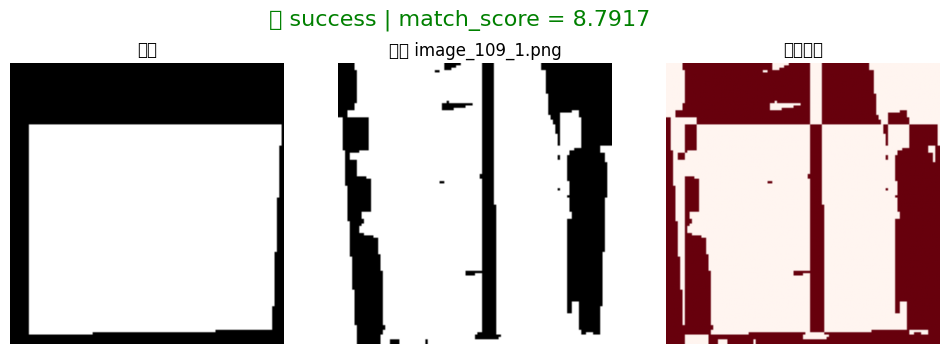

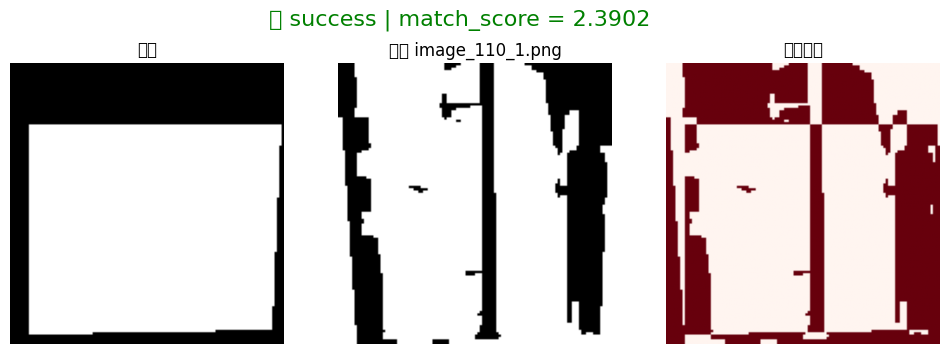

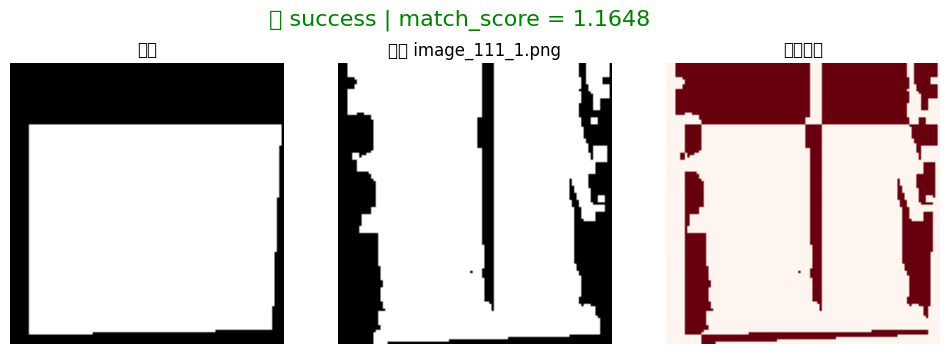

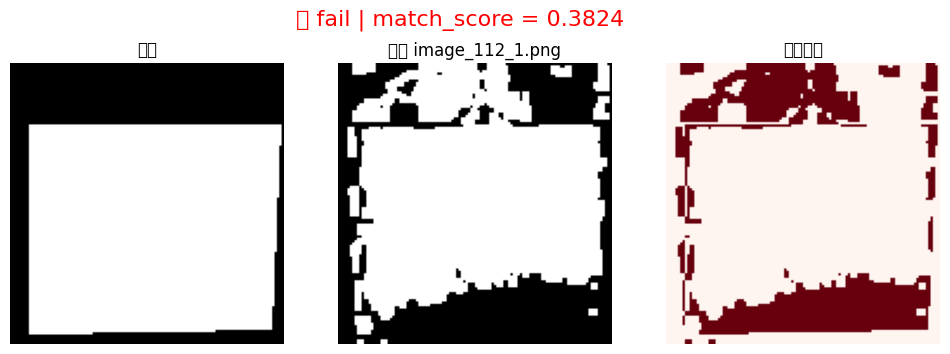

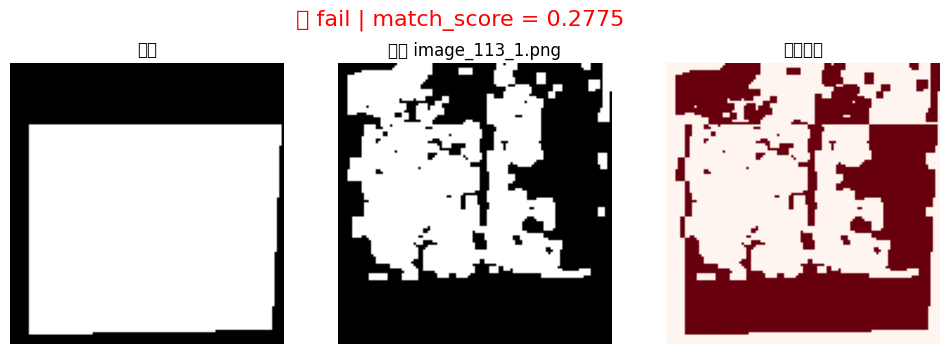

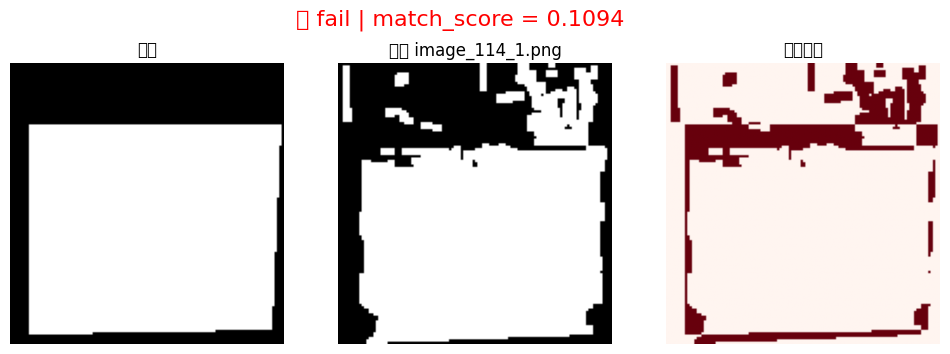

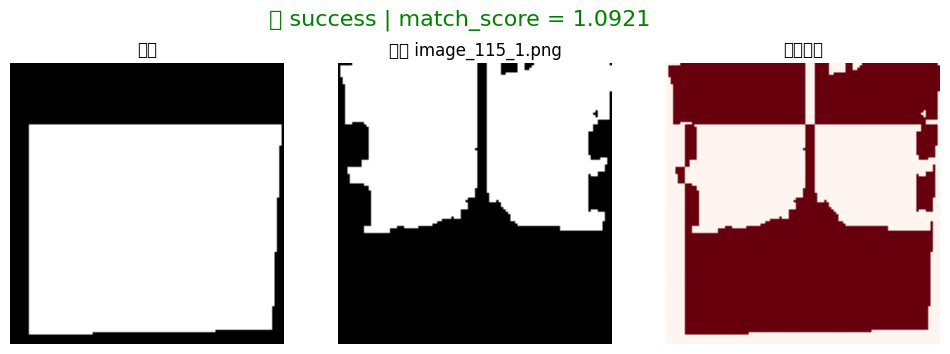

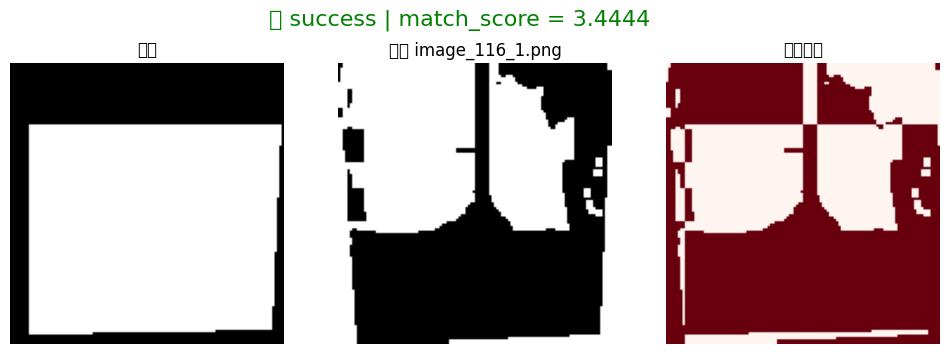

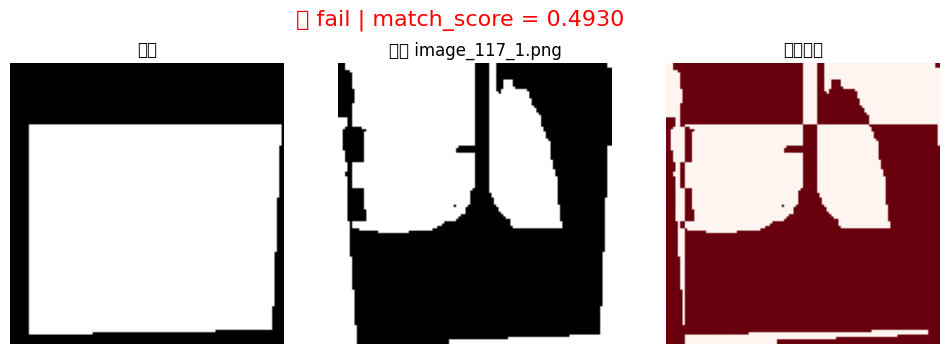

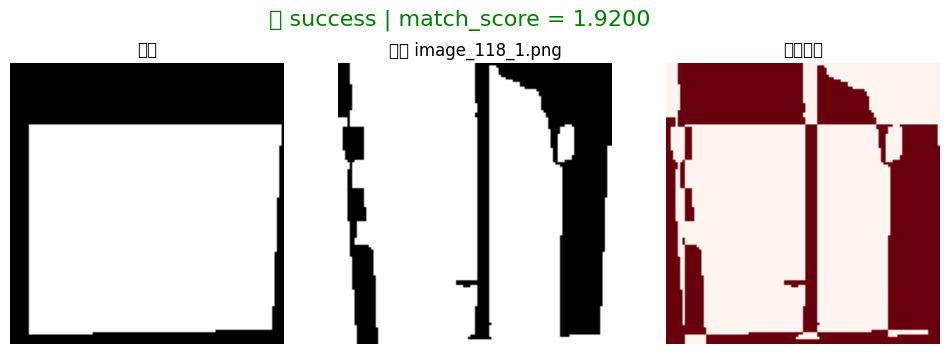

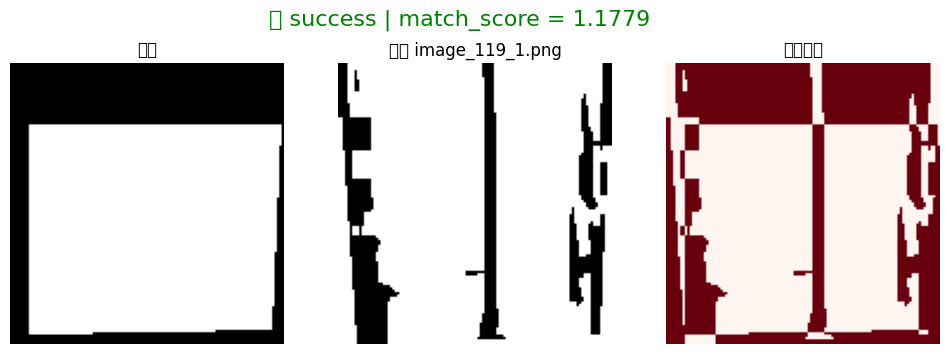


=== 辨識結果總表 ===
                  檔名     辨識結果  match_score
0      image_1_1.png  success     1.145833
1      image_2_1.png  success     0.901554
2      image_3_1.png  success     2.200000
3      image_4_1.png     fail     0.802083
4      image_5_1.png  success     4.608696
..               ...      ...          ...
114  image_115_1.png  success     1.092105
115  image_116_1.png  success     3.444444
116  image_117_1.png     fail     0.493023
117  image_118_1.png  success     1.920000
118  image_119_1.png  success     1.177885

[119 rows x 3 columns]

=== 辨識結果總表 ===
                  檔名     辨識結果  match_score
0      image_1_1.png  success     1.145833
1      image_2_1.png  success     0.901554
2      image_3_1.png  success     2.200000
3      image_4_1.png     fail     0.802083
4      image_5_1.png  success     4.608696
..               ...      ...          ...
114  image_115_1.png  success     1.092105
115  image_116_1.png  success     3.444444
116  image_117_1.png     fail     0.49302

In [91]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== ART1 類別 ==========
class ART1:
    def __init__(self, input_size, vigilance=0.7, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.bottom_up_weights = []
        self.top_down_weights = []
        self.num_categories = 0

    def register_template(self, template_vec):
        self.top_down_weights.append(list(template_vec))
        denominator = self.epsilon + sum(template_vec)
        normalized_bottom_up = [val / denominator for val in template_vec]
        self.bottom_up_weights.append(normalized_bottom_up)
        self.num_categories += 1

    def process_input(self, input_vec):
        if not self.bottom_up_weights:
            return -1, 0.0

        activations = []
        for weight in self.bottom_up_weights:
            activation = sum(input_vec[i] * weight[i] for i in range(self.input_size))
            activations.append(activation)

        if activations:
            winner_index = activations.index(max(activations))
        else:
            return -1, 0.0

        winner_top_down = self.top_down_weights[winner_index]
        numerator = sum(input_vec[i] * winner_top_down[i] for i in range(self.input_size))
        denominator = sum(input_vec) + self.epsilon
        match_score = numerator / denominator

        if match_score >= self.vigilance:
            return winner_index, match_score
        else:
            return -1, match_score

# ========== 設定樣本與資料夾 ==========
template_img = mask_0
test_folder = '/content/drive/MyDrive/night/0428/'
resize_shape = (100, 100)

# ========== 建立 樣本 ==========
_, template_binary = cv2.threshold(template_img, 128, 1, cv2.THRESH_BINARY)
template_vector = template_binary.flatten()

model = ART1(input_size=len(template_vector), vigilance=0.9, epsilon=1e-6)
model.register_template(template_vector)
print("✅ 樣本註冊完成")

# ========== 準備辨識資料 ==========
file_list = os.listdir(test_folder)
selected_files = [f for f in file_list if f.endswith('1.jpg') or f.endswith('1.png')]

print(f"\n共找到 {len(selected_files)} 張符合條件的圖片\n")

# ========== 開始辨識 + 收集結果 ==========
results = []

for idx, filename in enumerate(selected_files):
    file_path = os.path.join(test_folder, filename)

    test_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    _, test_binary = cv2.threshold(test_img, 128, 1, cv2.THRESH_BINARY)
    test_vector = test_binary.flatten()

    if len(test_vector) != model.input_size:
        print(f"❌ 圖片 {filename} 大小不符，跳過")
        results.append({'檔名': filename, '辨識結果': '尺寸不符', 'match_score': 0.0})
        continue

    category, match_score = model.process_input(test_vector)

    if category == -1:
        results.append({'檔名': filename, '辨識結果': 'fail', 'match_score': match_score})
    else:
        results.append({'檔名': filename, '辨識結果': 'success', 'match_score': match_score})

# ========== 建立 DataFrame 顯示結果 ======import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== ART1 類別 ==========
class ART1:
    def __init__(self, input_size, vigilance=0.7, epsilon=1e-6):
        self.input_size = input_size
        self.vigilance = vigilance
        self.epsilon = epsilon
        self.bottom_up_weights = []
        self.top_down_weights = []
        self.num_categories = 0

    def register_template(self, template_vec):
        self.top_down_weights.append(list(template_vec))
        denominator = self.epsilon + sum(template_vec)
        normalized_bottom_up = [val / denominator for val in template_vec]
        self.bottom_up_weights.append(normalized_bottom_up)
        self.num_categories += 1

    def process_input(self, input_vec):
        if not self.bottom_up_weights:
            return -1, 0.0

        activations = []
        for weight in self.bottom_up_weights:
            activation = sum(input_vec[i] * weight[i] for i in range(self.input_size))
            activations.append(activation)

        if activations:
            winner_index = activations.index(max(activations))
        else:
            return -1, 0.0

        winner_top_down = self.top_down_weights[winner_index]
        numerator = sum(input_vec[i] * winner_top_down[i] for i in range(self.input_size))
        denominator = sum(input_vec) + self.epsilon
        match_score = numerator / denominator

        if match_score >= self.vigilance:
            return winner_index, match_score
        else:
            return -1, match_score

# ========== 設定樣本與資料夾 ==========
template_img = mask_0
test_folder = '/content/drive/MyDrive/night/0428/'
resize_shape = (100, 100)

# ========== 建立 樣本 ==========
_, template_binary = cv2.threshold(template_img, 128, 1, cv2.THRESH_BINARY)
template_vector = template_binary.flatten()

model = ART1(input_size=len(template_vector), vigilance=0.9, epsilon=1e-6)
model.register_template(template_vector)
print("✅ 樣本註冊完成")

# ========== 準備辨識資料 ==========
file_list = os.listdir(test_folder)
selected_files = [f for f in file_list if f.endswith('1.jpg') or f.endswith('1.png')]

print(f"\n共找到 {len(selected_files)} 張符合條件的圖片\n")

# ========== 開始辨識 + 收集結果 ==========
results = []

for idx, filename in enumerate(selected_files):
    file_path = os.path.join(test_folder, filename)

    test_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    _, test_binary = cv2.threshold(test_img, 128, 1, cv2.THRESH_BINARY)
    test_vector = test_binary.flatten()

    if len(test_vector) != model.input_size:
        print(f"❌ 圖片 {filename} 大小不符，跳過")
        results.append({'檔名': filename, '辨識結果': '尺寸不符', 'match_score': 0.0})
        continue

    category, match_score = model.process_input(test_vector)

    # 收集辨識結果
    result_label = 'success' if category != -1 else 'fail'
    results.append({'檔名': filename, '辨識結果': result_label, 'match_score': match_score})

    # === 顯示樣本 vs 測試圖 + 錯誤區域圖 ===
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # 樣本圖
    axs[0].imshow(template_binary, cmap='gray')
    axs[0].set_title('樣本')
    axs[0].axis('off')

    # 測試圖
    axs[1].imshow(test_binary, cmap='gray')
    axs[1].set_title(f'圖片 {filename}')
    axs[1].axis('off')

    # 錯誤區域圖
    difference = np.abs(template_binary.astype(np.int32) - test_binary.astype(np.int32))
    axs[2].imshow(difference, cmap='Reds')
    axs[2].set_title('錯誤區域')
    axs[2].axis('off')

    # 整體標題
    plt.suptitle(
        f"{'✅ success' if category != -1 else '❌ fail'} | match_score = {match_score:.4f}",
        fontsize=16,
        color='green' if category != -1 else 'red'
    )
    plt.show()

# ========== 建立 DataFrame 顯示結果 ==========
df_results = pd.DataFrame(results)

print("\n=== 辨識結果總表 ===")
print(df_results)

df_results = pd.DataFrame(results)

print("\n=== 辨識結果總表 ===")
print(df_results)
